In [39]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

class PyTorchOCSVM(nn.Module):
    def __init__(self, input_dim, nu=0.1, device='cuda:0'):
        super(PyTorchOCSVM, self).__init__()
        self.nu = nu
        self.device = device
        self.input_dim = input_dim
        
        # Neural network layers for feature transformation
        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        ).to(device)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        return self.feature_net(x)

class OptimizedGPUOCSVM:
    def __init__(self, nu=0.1, scaler_type='standard', device='cuda:0', 
                 batch_size=256, learning_rate=0.001, epochs=100):
        """
        GPU-accelerated One-Class SVM using PyTorch
        
        Parameters:
        - nu: Upper bound on the fraction of training errors
        - scaler_type: 'standard' or 'robust' scaling
        - device: GPU device ('cuda:0', 'cuda:1', etc.)
        - batch_size: Batch size for training
        - learning_rate: Learning rate for optimization
        - epochs: Number of training epochs
        """
        self.nu = nu
        self.scaler_type = scaler_type
        self.device = device
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        # Check if GPU is available
        if not torch.cuda.is_available():
            print("CUDA not available, falling back to CPU")
            self.device = 'cpu'
        else:
            # Check if specified GPU exists
            gpu_count = torch.cuda.device_count()
            gpu_id = int(device.split(':')[1]) if ':' in device else 0
            if gpu_id >= gpu_count:
                print(f"GPU {gpu_id} not available, using GPU 0")
                self.device = 'cuda:0'
            else:
                print(f"Using GPU {gpu_id}: {torch.cuda.get_device_name(gpu_id)}")
        
        # Initialize components
        self.scaler = None
        self.model = None
        self.rho = 0.0  # Decision boundary parameter
        
    def _setup_scaler(self):
        """Setup the appropriate scaler"""
        if self.scaler_type == 'robust':
            return RobustScaler()
        else:
            return StandardScaler()
    
    def _preprocess_data(self, X, fit_scaler=False):
        """Preprocess data with scaling"""
        print(f"Data shape: {X.shape}")
        
        # Scaling
        print("Applying scaling...")
        start_time = time.time()
        if fit_scaler or self.scaler is None:
            self.scaler = self._setup_scaler()
            X_scaled = self.scaler.fit_transform(X)
        else:
            X_scaled = self.scaler.transform(X)
        print(f"Scaling completed in {time.time() - start_time:.2f} seconds")
        
        return X_scaled
    
    def _svdd_loss(self, outputs, R, center):
        """
        Support Vector Data Description (SVDD) loss function
        """
        # Distance from center
        distances = torch.sum((outputs - center) ** 2, dim=1)
        
        # SVDD loss with penalty for points outside the sphere
        loss = R ** 2 + (1 / (self.nu * len(outputs))) * torch.sum(
            torch.clamp(distances - R ** 2, min=0)
        )
        
        return loss, distances
    
    def fit(self, X):
        """Fit the GPU-accelerated One-Class SVM model"""
        print("Starting GPU One-Class SVM training...")
        print(f"Using device: {self.device}")
        
        # Preprocess data
        X_processed = self._preprocess_data(X, fit_scaler=True)
        
        # Convert to PyTorch tensors
        X_tensor = torch.FloatTensor(X_processed).to(self.device)
        
        # Create data loader
        dataset = TensorDataset(X_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Initialize model
        input_dim = X_processed.shape[1]
        self.model = PyTorchOCSVM(input_dim, self.nu, self.device)
        
        # Optimizer
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
        
        print(f"Training on {len(X_processed)} samples with {input_dim} features")
        print(f"Batch size: {self.batch_size}, Epochs: {self.epochs}")
        
        # Training loop
        self.model.train()
        start_time = time.time()
        
        # Initialize center and radius
        with torch.no_grad():
            sample_outputs = self.model(X_tensor[:1000])  # Use first 1000 samples
            center = torch.mean(sample_outputs, dim=0)
            R = torch.tensor(1.0, device=self.device, requires_grad=True)
        
        # Add R to optimizer
        optimizer.add_param_group({'params': [R]})
        
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            num_batches = 0
            
            for batch_idx, (data,) in enumerate(dataloader):
                optimizer.zero_grad()
                
                # Forward pass
                outputs = self.model(data)
                
                # Compute loss
                loss, distances = self._svdd_loss(outputs, R, center)
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                num_batches += 1
                
                # Update center (moving average)
                with torch.no_grad():
                    center = 0.9 * center + 0.1 * torch.mean(outputs, dim=0)
            
            scheduler.step()
            avg_loss = epoch_loss / num_batches
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {avg_loss:.6f}, R: {R.item():.6f}")
        
        # Store final parameters
        self.rho = R.item()
        self.center = center.detach()
        
        training_time = time.time() - start_time
        print(f"GPU OCSVM training completed in {training_time:.2f} seconds")
        
        return self
    
    def predict(self, X):
        """Predict using the fitted model"""
        if self.model is None:
            raise ValueError("Model must be fitted before prediction")
        
        self.model.eval()
        X_processed = self._preprocess_data(X)
        X_tensor = torch.FloatTensor(X_processed).to(self.device)
        
        predictions = []
        with torch.no_grad():
            for i in range(0, len(X_tensor), self.batch_size):
                batch = X_tensor[i:i+self.batch_size]
                outputs = self.model(batch)
                distances = torch.sum((outputs - self.center) ** 2, dim=1)
                
                # -1 for outliers, 1 for normal
                batch_pred = torch.where(distances <= self.rho ** 2, 1, -1)
                predictions.append(batch_pred.cpu().numpy())
        
        return np.concatenate(predictions)
    
    def decision_function(self, X):
        """Compute the decision function"""
        if self.model is None:
            raise ValueError("Model must be fitted before prediction")
        
        self.model.eval()
        X_processed = self._preprocess_data(X)
        X_tensor = torch.FloatTensor(X_processed).to(self.device)
        
        decisions = []
        with torch.no_grad():
            for i in range(0, len(X_tensor), self.batch_size):
                batch = X_tensor[i:i+self.batch_size]
                outputs = self.model(batch)
                distances = torch.sum((outputs - self.center) ** 2, dim=1)
                
                # Negative distance (higher is more normal)
                batch_decisions = -distances
                decisions.append(batch_decisions.cpu().numpy())
        
        return np.concatenate(decisions)
    
    def save_model(self, filepath):
        """Save the complete trained model"""
        if self.model is None:
            raise ValueError("No model to save")
        
        # Move model to CPU for saving
        model_cpu = self.model.cpu()
        center_cpu = self.center.cpu() if hasattr(self, 'center') else None
        
        model_dict = {
            'model_state_dict': model_cpu.state_dict(),
            'scaler': self.scaler,
            'nu': self.nu,
            'rho': self.rho,
            'center': center_cpu,
            'input_dim': model_cpu.input_dim,
            'scaler_type': self.scaler_type,
            'device': self.device,
            'batch_size': self.batch_size,
            'learning_rate': self.learning_rate,
            'epochs': self.epochs
        }
        
        torch.save(model_dict, filepath)
        print(f"Complete model saved to {filepath}")
        
        # Move model back to original device
        self.model.to(self.device)
        if hasattr(self, 'center'):
            self.center = self.center.to(self.device)
    
    def load_model(self, filepath):
        """Load a trained model"""
        checkpoint = torch.load(filepath, map_location=self.device)
        
        # Restore model parameters
        self.nu = checkpoint['nu']
        self.rho = checkpoint['rho']
        self.center = checkpoint['center'].to(self.device) if checkpoint['center'] is not None else None
        self.scaler = checkpoint['scaler']
        self.scaler_type = checkpoint['scaler_type']
        self.batch_size = checkpoint['batch_size']
        self.learning_rate = checkpoint['learning_rate']
        self.epochs = checkpoint['epochs']
        
        # Recreate model
        input_dim = checkpoint['input_dim']
        self.model = PyTorchOCSVM(input_dim, self.nu, self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        
        print(f"Model loaded from {filepath}")

def list_available_gpus():
    """List available GPUs"""
    if torch.cuda.is_available():
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            gpu_name = torch.cuda.get_device_name(i)
            gpu_memory = torch.cuda.get_device_properties(i).total_memory / 1024**3
            print(f"  GPU {i}: {gpu_name} ({gpu_memory:.1f} GB)")
        return [f"cuda:{i}" for i in range(gpu_count)]
    else:
        print("No CUDA GPUs available")
        return ["cpu"]

def main(gpu_id=0, nu=0.05, batch_size=512, learning_rate=0.001, epochs=50):
    """
    Main function to train GPU OCSVM on TCGA dataset
    
    Parameters:
    - gpu_id: GPU ID to use for training (0, 1, 2, 3, etc.)
    - nu: Upper bound on the fraction of training errors (default: 0.05)
    - batch_size: Batch size for training (default: 512)
    - learning_rate: Learning rate for optimization (default: 0.001)
    - epochs: Number of training epochs (default: 50)
    """
    
    # List available GPUs
    print("="*50)
    print("GPU DETECTION")
    print("="*50)
    available_devices = list_available_gpus()
    
    # Load data
    print("\n" + "="*50)
    print("LOADING DATA")
    print("="*50)
    try:
        df = pd.read_parquet('tcga_class0.parquet')
        print(f"Dataset loaded successfully. Shape: {df.shape}")
    except FileNotFoundError:
        print("Error: tcga_class0.parquet not found in current directory")
        return
    
    # Remove first column (irrelevant)
    X = df.iloc[:, 1:].values
    print(f"Feature matrix shape after removing first column: {X.shape}")
    
    # Check for missing values
    if np.any(np.isnan(X)):
        print("Warning: Dataset contains NaN values. Filling with median...")
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='median')
        X = imputer.fit_transform(X)
    
    # Training configuration
    print("\n" + "="*50)
    print("TRAINING CONFIGURATION")
    print("="*50)
    
    # Select GPU based on user input
    if torch.cuda.is_available():
        gpu_count = torch.cuda.device_count()
        if gpu_id >= gpu_count:
            print(f"Warning: GPU {gpu_id} not available. Available GPUs: 0-{gpu_count-1}")
            gpu_id = 0
            print(f"Falling back to GPU {gpu_id}")
        device = f"cuda:{gpu_id}"
    else:
        print("CUDA not available, using CPU")
        device = "cpu"
    
    print(f"Selected device: {device}")
    print(f"Training parameters: nu={nu}, batch_size={batch_size}, lr={learning_rate}, epochs={epochs}")
    
    # Initialize GPU OCSVM
    model = OptimizedGPUOCSVM(
        nu=nu,
        scaler_type='standard',
        device=device,
        batch_size=batch_size,
        learning_rate=learning_rate,
        epochs=epochs
    )
    
    print("\n" + "="*50)
    print("TRAINING")
    print("="*50)
    
    # Train the model
    start_time = time.time()
    model.fit(X)
    total_time = time.time() - start_time
    
    print(f"Total training time: {total_time:.2f} seconds")
    
    # Make predictions on the same data (for demonstration)
    print("\n" + "="*50)
    print("EVALUATION")
    print("="*50)
    
    predictions = model.predict(X)
    n_outliers = np.sum(predictions == -1)
    print(f"Detected outliers: {n_outliers} ({n_outliers/len(X)*100:.2f}%)")
    
    
    # Save the model with GPU ID in filename
    print("\n" + "="*50)
    print("SAVING MODEL")
    print("="*50)
    
    filename = f'OSVM_TCGA_class0_20kfeatures_gpu{gpu_id}.pkl'
    model.save_model(filename)
    print(f"Training completed successfully on GPU {gpu_id}!")
    
    return model

def train_with_specific_gpu(gpu_id, X):
    """Train model on a specific GPU"""
    device = f"cuda:{gpu_id}"
    model = OptimizedGPUOCSVM(
        nu=0.05,
        scaler_type='standard',
        device=device,
        batch_size=512,
        learning_rate=0.001,
        epochs=50
    )
    return model.fit(X)

def analyze_gpu_memory_usage():
    """Analyze GPU memory usage"""
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            memory_allocated = torch.cuda.memory_allocated(i) / 1024**3
            memory_reserved = torch.cuda.memory_reserved(i) / 1024**3
            memory_total = torch.cuda.get_device_properties(i).total_memory / 1024**3
            print(f"GPU {i}: {memory_allocated:.2f}GB / {memory_total:.2f}GB allocated")
            print(f"GPU {i}: {memory_reserved:.2f}GB / {memory_total:.2f}GB reserved")

def analyze_outliers(model, X, feature_names=None):
    """Analyze detected outliers"""
    predictions = model.predict(X)
    decisions = model.decision_function(X)
    
    outlier_indices = np.where(predictions == -1)[0]
    normal_indices = np.where(predictions == 1)[0]
    
    print(f"Normal samples: {len(normal_indices)} ({len(normal_indices)/len(X)*100:.2f}%)")
    print(f"Outlier samples: {len(outlier_indices)} ({len(outlier_indices)/len(X)*100:.2f}%)")
    print(f"Decision function range: [{np.min(decisions):.4f}, {np.max(decisions):.4f}]")
    
    return outlier_indices, normal_indices, decisions

# Example usage for training on a specific GPU
def train_on_gpu(gpu_id=0):
    """
    Example function to train on a specific GPU
    Usage: train_on_gpu(2)  # Train on GPU 2
    """
    # Load data
    df = pd.read_parquet('tcga_class0.parquet')
    X = df.iloc[:, 1:].values
    
    # Check for missing values
    if np.any(np.isnan(X)):
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='median')
        X = imputer.fit_transform(X)
    
    # Train on specific GPU
    device = f"cuda:{gpu_id}"
    model = OptimizedGPUOCSVM(
        nu=0.05,
        scaler_type='standard',
        device=device,
        batch_size=512,
        learning_rate=0.001,
        epochs=50
    )
    
    model.fit(X)
    model.save_model(f'OSVM_TCGA_class0_20kfeatures_gpu{gpu_id}.pkl')
    
    return model

if __name__ == "__main__":
    # Default parameters - modify these as needed
    main(gpu_id=2)  # Change gpu_id here: 0, 1, 2, or 3
    
# Example usage in Jupyter notebook:
# 
# # Train on GPU 0 (default)
# model = main(gpu_id=0)
#
# # Train on GPU 2 with custom parameters
# model = main(gpu_id=2, nu=0.1, batch_size=1024, epochs=100)
#
# # Train on GPU 3 with all custom parameters
# model = main(gpu_id=3, nu=0.05, batch_size=256, learning_rate=0.0005, epochs=75)

GPU DETECTION
Available GPUs: 4
  GPU 0: NVIDIA GeForce RTX 2080 Ti (10.8 GB)
  GPU 1: NVIDIA GeForce RTX 2080 Ti (10.8 GB)
  GPU 2: NVIDIA GeForce RTX 2080 Ti (10.8 GB)
  GPU 3: NVIDIA GeForce RTX 2080 Ti (10.8 GB)

LOADING DATA
Dataset loaded successfully. Shape: (669, 19888)
Feature matrix shape after removing first column: (669, 19887)

TRAINING CONFIGURATION
Selected device: cuda:2
Training parameters: nu=0.05, batch_size=512, lr=0.001, epochs=50
Using GPU 2: NVIDIA GeForce RTX 2080 Ti

TRAINING
Starting GPU One-Class SVM training...
Using device: cuda:2
Data shape: (669, 19887)
Applying scaling...
Scaling completed in 0.47 seconds
Training on 669 samples with 19887 features
Batch size: 512, Epochs: 50
Epoch [10/50], Loss: 56.907642, R: 1.018959
Epoch [20/50], Loss: 10.045147, R: 1.032105
Epoch [30/50], Loss: 3.197116, R: 1.035957
Epoch [40/50], Loss: 2.412402, R: 1.035674
Epoch [50/50], Loss: 2.623486, R: 1.034635
GPU OCSVM training completed in 0.65 seconds
Total training time: 

In [44]:
import torch
import numpy as np
import pandas as pd
import time
import os
from tqdm import tqdm
import math


class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 2000)
        self.bn1 = torch.nn.BatchNorm1d(2000)
        self.dropout1 = torch.nn.Dropout(0.02)
        self.fc2 = torch.nn.Linear(2000, 200)
        self.bn2 = torch.nn.BatchNorm1d(200)
        self.dropout2 = torch.nn.Dropout(0.02)
        self.fc3 = torch.nn.Linear(200, 20)
        self.bn3 = torch.nn.BatchNorm1d(20)
        self.dropout3 = torch.nn.Dropout(0.02)
        self.fc4 = torch.nn.Linear(20, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.leaky_relu = torch.nn.LeakyReLU(0.01)
        
    def forward(self, x):
        # Handle batch norm for single samples if needed
        if x.dim() == 2 and x.size(0) == 1:
            # For a single sample, clone it to make a batch of 2
            x_batch = torch.cat([x, x], dim=0)
            x_batch = self.leaky_relu(self.bn1(self.fc1(x_batch)))
            x_batch = self.dropout1(x_batch)
            x_batch = self.leaky_relu(self.bn2(self.fc2(x_batch)))
            x_batch = self.dropout2(x_batch)
            x_batch = self.leaky_relu(self.bn3(self.fc3(x_batch)))
            x_batch = self.dropout3(x_batch)
            x_batch = self.sigmoid(self.fc4(x_batch))
            return x_batch[0:1]  # Return only the first sample
        else:
            # Normal batch processing
            x = self.leaky_relu(self.bn1(self.fc1(x)))
            x = self.dropout1(x)
            x = self.leaky_relu(self.bn2(self.fc2(x)))
            x = self.dropout2(x)
            x = self.leaky_relu(self.bn3(self.fc3(x)))
            x = self.dropout3(x)
            x = self.sigmoid(self.fc4(x))
            return x
        
    def find_boundary_intersection(self, x_factual, x_counterfactual, eps=1e-5, max_iterations=50):
        """
        Find the point on the decision boundary that intersects the line between factual and counterfactual
        
        Args:
            x_factual: Factual sample tensor
            x_counterfactual: Counterfactual sample tensor
            eps: Precision threshold
            max_iterations: Maximum number of binary search iterations
            
        Returns:
            Intersection point and distance from factual to intersection
        """
        with torch.no_grad():
            # Get predictions for both points
            fact_pred = self.forward(x_factual).item()
            cf_pred = self.forward(x_counterfactual).item()
            
            # Check if predictions are different enough (i.e., on opposite sides of the boundary)
            # Use a slightly relaxed condition to handle border cases
            if (fact_pred > 0.55 and cf_pred > 0.55) or (fact_pred < 0.45 and cf_pred < 0.45):
                # If both are clearly on the same side, use the distance to counterfactual
                # This is a reasonable fallback rather than returning infinity
                return x_counterfactual, torch.sum(torch.abs(x_counterfactual - x_factual)).item()
            
            # Direction vector from factual to counterfactual
            direction = x_counterfactual - x_factual
            
            # Get direction magnitude (for normalizing)
            direction_mag = torch.norm(direction, p=1).item()
            if direction_mag < eps:  # If points are too close
                return x_factual, 0.0
                
            # Initialize binary search
            low = 0.0  # factual point
            high = 1.0  # counterfactual point
            
            # Binary search for the decision boundary
            for _ in range(max_iterations):
                mid = (low + high) / 2.0
                x_mid = x_factual + mid * direction
                pred_mid = self.forward(x_mid).item()
                
                # Check if we're close enough to the boundary
                if abs(pred_mid - 0.5) < eps:
                    # Calculate L1 distance from factual to intersection
                    distance = torch.sum(torch.abs(x_mid - x_factual)).item()
                    return x_mid, distance
                
                # Update search range
                if (pred_mid > 0.5 and fact_pred > 0.5) or (pred_mid < 0.5 and fact_pred < 0.5):
                    # Mid point is on same side as factual
                    low = mid
                else:
                    # Mid point is on same side as counterfactual
                    high = mid
                    
                # Check if our search range is small enough
                if high - low < eps:
                    x_intersection = x_factual + mid * direction
                    distance = torch.sum(torch.abs(x_intersection - x_factual)).item()
                    return x_intersection, distance
            
            # If we reach max iterations, return the midpoint
            x_intersection = x_factual + ((low + high) / 2.0) * direction
            distance = torch.sum(torch.abs(x_intersection - x_factual)).item()
            return x_intersection, distance

def load_model(model_path, input_size, device):
    """Load the pretrained MLP model"""
    model = MLP(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def compute_median_absolute_deviation(data_tensor):
    """Compute median absolute deviation for each feature"""
    median = torch.median(data_tensor, dim=0).values
    deviation = torch.abs(data_tensor - median)
    mad = torch.median(deviation, dim=0).values
    # Replace zero MAD values with 1 to avoid division by zero
    mad[mad == 0] = 1.0
    return mad

def update_evaluation_file(name, metric, value, results, output_file="evaluation.txt"):
    """Update the evaluation file with the current results"""
    # Store the result - don't write to file yet (will be done at the end)
    results[name][metric] = value
    
    # Print the update
    print(f"Updated results with {name} - {metric}: {value:.4f}")
    
    return results

def compute_gaussian_probability(distance, mean, variance):
    """
    Compute the probability P(abs(x-mean) > abs(distance-mean))
    This gives the probability of being further from the mean than this distance
    """
    # Calculate how far we are from the mean
    distance_from_mean = abs(distance - mean)
    
    # Compute the probability of being further from the mean (one-sided)
    # This is equivalent to 2 * (1 - CDF(|x-mean|))
    z_score = distance_from_mean / math.sqrt(variance)
    probability = 2 * (1 - 0.5 * (1 + math.erf(z_score / math.sqrt(2))))
    
    return probability


import json

@torch.no_grad()
def evaluate_counterfactuals(
    original_data_path,
    counterfactual_dfs,
    model_path,
    metrics_to_compute={
        'validity': True,
        'proximity': True,
        'sparsity': True,
        'sparsity_count': True,
        'diversity': True,
        'sparse_diversity': True,
        'avg_10nn_distance': True,
        'avg_10nn_dataset': True,
        'avg_10nn_class0': True
    },
    batch_size=512,
    gpu_id=0,
    output_path="evaluation_results.json"
):
    """
    Evaluate counterfactuals using multiple metrics
    
    Args:
        original_data_path: Path to original data
        counterfactual_dfs: Dictionary mapping names to counterfactual DataFrames or paths
        model_path: Path to trained model
        metrics_to_compute: Dictionary specifying which metrics to compute
        batch_size: Batch size for GPU processing
        gpu_id: GPU device ID to use
        output_path: Path to output evaluation results as JSON
        
    Returns:
        Dictionary of evaluation results per counterfactual set
    """
    start_time = time.time()
    
    # Set device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load original data
    print("Loading original data...")
    original_df = pd.read_parquet(original_data_path)
    
    # Process counterfactual dataframes
    cf_data = {}
    for name, cf_df_or_path in counterfactual_dfs.items():
        if isinstance(cf_df_or_path, str):
            cf_data[name] = pd.read_parquet(cf_df_or_path)
        else:
            cf_data[name] = cf_df_or_path
    
    # Extract feature names (excluding class column and original_index)
    feature_names = list(original_df.columns)[1:]  # Exclude first column (class)
    num_features = len(feature_names)
    
    # Load model
    model = load_model(model_path, num_features, device)
    
    # Prepare data for GPU
    # Convert original data to tensor (exclude class column)
    original_features = torch.tensor(original_df.iloc[:, 1:].values, dtype=torch.float32, device=device)
    
    # Compute median absolute deviation (MAD) for normalization
    mad = compute_median_absolute_deviation(original_features)
    
    # Extract class information
    original_classes = original_df.iloc[:, 0].values
    
    # Create dictionary to store results
    results = {name: {} for name in cf_data.keys()}
    
    # Gaussian parameters for new metrics
    dataset_gaussian_mean = 8304.722022
    dataset_gaussian_variance = 4707926.898804
    class0_gaussian_mean = 5950.676427
    class0_gaussian_variance = 3400381.504375
    
    # Pre-compute class 0 mask for the original data
    class0_mask = torch.tensor(original_classes == 0, device=device)
    class0_samples = original_features[class0_mask] if torch.any(class0_mask) else None
    
    # Process each counterfactual dataset
    for name, cf_df in cf_data.items():
        print(f"\nEvaluating: {name}")
        
        # FIXED: Direct mapping from counterfactual to original row positions
        cf_to_orig_map = {}
        if 'original_index' in cf_df.columns:
            for i, row in enumerate(cf_df.itertuples()):
                # original_index directly gives the row position in data_norm
                orig_position = int(row.original_index)
                if 0 <= orig_position < len(original_df):
                    cf_to_orig_map[i] = orig_position
                else:
                    cf_to_orig_map[i] = -1
        else:
            # Assume sample_id column refers to row positions as well
            for i, row in enumerate(cf_df.itertuples()):
                if hasattr(row, 'sample_id'):
                    orig_position = int(row.sample_id)
                    if 0 <= orig_position < len(original_df):
                        cf_to_orig_map[i] = orig_position
                    else:
                        cf_to_orig_map[i] = -1
                else:
                    cf_to_orig_map[i] = -1
        
        # Convert counterfactual features to tensor (exclude class column and original_index/sample_id)
        if 'original_index' in cf_df.columns:
            cf_features = torch.tensor(cf_df.iloc[:, 1:-1].values, dtype=torch.float32, device=device)
        else:
            # Assume first column is class and rest are features (no original_index)
            cf_features = torch.tensor(cf_df.iloc[:, 1:].values, dtype=torch.float32, device=device)
        
        # Organize counterfactuals by original index
        cf_by_orig = {}
        for cf_idx, orig_idx in cf_to_orig_map.items():
            if orig_idx != -1:
                if orig_idx not in cf_by_orig:
                    cf_by_orig[orig_idx] = []
                cf_by_orig[orig_idx].append(cf_idx)
        
        # Store metric values for this counterfactual set
        metric_values = {}
        
        # ------ Compute metrics ------
        
        # 1. Validity
        if metrics_to_compute.get('validity', False):
            print("Computing validity...")
            validity_scores = []
            
            # Process in batches
            for start_idx in range(0, len(cf_features), batch_size):
                end_idx = min(start_idx + batch_size, len(cf_features))
                batch_cf = cf_features[start_idx:end_idx]
                
                # Get original indices for this batch
                batch_orig_indices = [cf_to_orig_map.get(i, -1) for i in range(start_idx, end_idx)]
                
                # Filter out invalid mappings
                valid_indices = [(i, orig_idx) for i, orig_idx in enumerate(batch_orig_indices) if orig_idx != -1]
                if not valid_indices:
                    continue
                
                # Split into cf indices and orig indices
                batch_cf_indices, batch_orig_indices = zip(*valid_indices)
                
                # Get predictions for valid counterfactuals
                valid_cf = batch_cf[list(batch_cf_indices)]
                cf_preds = model(valid_cf).cpu().numpy()
                
                # Get predictions for corresponding original samples
                orig_samples = original_features[list(batch_orig_indices)]
                orig_preds = model(orig_samples).cpu().numpy()
                
                # Compute validity for each counterfactual
                for cf_pred, orig_pred in zip(cf_preds, orig_preds):
                    # Binary label change (0 or 1)
                    validity_score = abs(float(cf_pred > 0.5) - float(orig_pred >= 0.5))
                    validity_scores.append(validity_score)
            
            if validity_scores:
                min_val = float(np.min(validity_scores))
                avg_val = float(np.mean(validity_scores))
                max_val = float(np.max(validity_scores))
                std_val = float(np.std(validity_scores))
                metric_values['validity'] = [min_val, avg_val, max_val, std_val]
                print(f"validity: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
        
        # 2-3. Proximity and Sparsity
        if metrics_to_compute.get('proximity', False) or metrics_to_compute.get('sparsity', False) or metrics_to_compute.get('sparsity_count', False):
            print("Computing proximity and sparsity...")
            proximity_scores = []
            sparsity_scores = []
            sparsity_count_scores = []
            
            # Process in batches
            for start_idx in range(0, len(cf_features), batch_size):
                end_idx = min(start_idx + batch_size, len(cf_features))
                batch_cf = cf_features[start_idx:end_idx]
                
                # Get original indices for this batch
                batch_orig_indices = [cf_to_orig_map.get(i, -1) for i in range(start_idx, end_idx)]
                
                # Filter out invalid mappings
                valid_indices = [(i, orig_idx) for i, orig_idx in enumerate(batch_orig_indices) if orig_idx != -1]
                if not valid_indices:
                    continue
                
                # Split into cf indices and orig indices
                batch_cf_indices, batch_orig_indices = zip(*valid_indices)
                
                # Get valid counterfactuals and corresponding original samples
                valid_cf = batch_cf[list(batch_cf_indices)]
                orig_samples = original_features[list(batch_orig_indices)]
                
                # Compute absolute differences
                abs_diff = torch.abs(valid_cf - orig_samples)
                
                # Compute proximity (L1 distance normalized by MAD)
                if metrics_to_compute.get('proximity', False):
                    normalized_diff = abs_diff / mad
                    batch_proximity = torch.mean(normalized_diff, dim=1)
                    proximity_scores.extend(batch_proximity.cpu().numpy())
                
                # Compute sparsity (1 - proportion of changed features)
                if metrics_to_compute.get('sparsity', False):
                    # Consider a feature changed if abs_diff > 1e-2
                    changed_features = (abs_diff > 1e-2).float()
                    batch_sparsity = 1 - torch.mean(changed_features, dim=1)
                    sparsity_scores.extend(batch_sparsity.cpu().numpy())
                    
                # Compute sparsity count (raw count of changed features)
                if metrics_to_compute.get('sparsity_count', False):
                    changed_count = torch.sum((abs_diff > 1e-2).float(), dim=1)
                    sparsity_count_scores.extend(changed_count.cpu().numpy())
            
            if metrics_to_compute.get('proximity', False) and proximity_scores:
                min_val = float(np.min(proximity_scores))
                avg_val = float(np.mean(proximity_scores))
                max_val = float(np.max(proximity_scores))
                std_val = float(np.std(proximity_scores))
                metric_values['proximity'] = [min_val, avg_val, max_val, std_val]
                print(f"proximity: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
                
            if metrics_to_compute.get('sparsity', False) and sparsity_scores:
                min_val = float(np.min(sparsity_scores))
                avg_val = float(np.mean(sparsity_scores))
                max_val = float(np.max(sparsity_scores))
                std_val = float(np.std(sparsity_scores))
                metric_values['sparsity'] = [min_val, avg_val, max_val, std_val]
                print(f"sparsity: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
                    
            if metrics_to_compute.get('sparsity_count', False) and sparsity_count_scores:
                min_val = float(np.min(sparsity_count_scores))
                avg_val = float(np.mean(sparsity_count_scores))
                max_val = float(np.max(sparsity_count_scores))
                std_val = float(np.std(sparsity_count_scores))
                metric_values['sparsity_count'] = [min_val, avg_val, max_val, std_val]
                print(f"sparsity_count: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
        
        # 4. Diversity
        if metrics_to_compute.get('diversity', False):
            print("Computing diversity...")
            diversity_scores = []
            
            # For each original sample, compute diversity of its counterfactuals
            for orig_idx, cf_indices in cf_by_orig.items():
                if len(cf_indices) > 1:  # Need at least 2 CFs to compute diversity
                    # Get counterfactuals for this original sample
                    orig_cfs = cf_features[cf_indices]
                    
                    # Compute pairwise distances using torch.cdist (fully vectorized)
                    # Using raw L1 distances without MAD normalization
                    pairwise_distances = torch.cdist(orig_cfs, orig_cfs, p=1)
                    
                    # Extract the upper triangular part (excluding diagonal)
                    mask = torch.triu(torch.ones_like(pairwise_distances), diagonal=1).bool()
                    distances = pairwise_distances[mask]
                    
                    # Compute average distance
                    if len(distances) > 0:
                        avg_distance = torch.mean(distances).item()
                        diversity_scores.append(avg_distance)
            
            if diversity_scores:
                min_val = float(np.min(diversity_scores))
                avg_val = float(np.mean(diversity_scores))
                max_val = float(np.max(diversity_scores))
                std_val = float(np.std(diversity_scores))
                metric_values['diversity'] = [min_val, avg_val, max_val, std_val]
                print(f"diversity: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
        
        # 5. Sparse Diversity
        if metrics_to_compute.get('sparse_diversity', False):
            print("Computing sparse diversity...")
            sparse_diversity_scores = []
            
            # For each original sample, compute sparse diversity of its counterfactuals
            for orig_idx, cf_indices in cf_by_orig.items():
                if len(cf_indices) > 1:  # Need at least 2 CFs to compute diversity
                    # Get counterfactuals for this original sample
                    orig_cfs = cf_features[cf_indices]
                    orig_sample = original_features[orig_idx]
                    
                    # Identify changed features for each counterfactual (binary mask)
                    changed_features = (torch.abs(orig_cfs - orig_sample.unsqueeze(0)) > 1e-5).float()
                    
                    # Number of counterfactuals
                    n_cfs = len(cf_indices)
                    
                    # Vectorized intersection computation
                    # Changed features is [n_cfs, num_features]
                    # We'll compute intersection for all pairs at once
                    
                    # Create expanded tensors for broadcasting
                    # [n_cfs, 1, num_features] and [1, n_cfs, num_features]
                    features_i = changed_features.unsqueeze(1)
                    features_j = changed_features.unsqueeze(0)
                    
                    # Compute intersection and union for all pairs
                    intersection = torch.sum(features_i * features_j, dim=2)  # [n_cfs, n_cfs]
                    union = torch.sum(torch.clamp(features_i + features_j, 0, 1), dim=2)  # [n_cfs, n_cfs]
                    
                    # Create a mask for valid pairs (upper triangle, excluding diagonal)
                    mask = torch.triu(torch.ones(n_cfs, n_cfs, device=device), diagonal=1).bool()
                    
                    # Get valid intersection and union values
                    valid_intersection = intersection[mask]
                    valid_union = union[mask]
                    
                    # Compute IoU (avoid division by zero)
                    valid_mask = valid_union > 0
                    if torch.any(valid_mask):
                        iou = torch.zeros_like(valid_intersection)
                        iou[valid_mask] = valid_intersection[valid_mask] / valid_union[valid_mask]
                        
                        # Compute average IoU
                        avg_overlap = torch.mean(iou).item()
                        sparse_diversity_scores.append(1 - avg_overlap)
            
            if sparse_diversity_scores:
                min_val = float(np.min(sparse_diversity_scores))
                avg_val = float(np.mean(sparse_diversity_scores))
                max_val = float(np.max(sparse_diversity_scores))
                std_val = float(np.std(sparse_diversity_scores))
                metric_values['sparse_diversity'] = [min_val, avg_val, max_val, std_val]
                print(f"sparse_diversity: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
        
        # 6-8. New Metrics: Average 10-NN Distance and Probabilities
        # Initialize storage for distances
        avg_10nn_distances_list = []
        avg_10nn_dataset_probs = []
        avg_10nn_class0_probs = []
        
        # First compute k-NN distances for each counterfactual
        if metrics_to_compute.get('avg_10nn_distance', False) or metrics_to_compute.get('avg_10nn_dataset', False) or metrics_to_compute.get('avg_10nn_class0', False):
            print("Computing 10-NN distances in dataset and class 0...")
            
            # Process counterfactuals in batches
            for start_idx in range(0, len(cf_features), batch_size):
                end_idx = min(start_idx + batch_size, len(cf_features))
                batch_cf = cf_features[start_idx:end_idx]
                
                # Get mappings for this batch
                batch_orig_indices = [cf_to_orig_map.get(i, -1) for i in range(start_idx, end_idx)]
                valid_mask = torch.tensor([idx != -1 for idx in batch_orig_indices], device=device)
                
                if not torch.any(valid_mask):
                    continue
                
                valid_cf = batch_cf[valid_mask]
                valid_orig_indices = [idx for idx in batch_orig_indices if idx != -1]
                
                # Find the 10 nearest neighbors in the entire dataset
                if metrics_to_compute.get('avg_10nn_distance', False) or metrics_to_compute.get('avg_10nn_dataset', False):
                    # Initialize storage for 10-NN distances
                    k = 11  # k+1 to avoid counting self (though unlikely to be exact match)
                    knn_distances = torch.full((len(valid_cf), k), float('inf'), device=device)
                    
                    # Process original data in chunks
                    chunk_size = 5000  # Adjust based on available GPU memory
                    for chunk_start in range(0, len(original_features), chunk_size):
                        chunk_end = min(chunk_start + chunk_size, len(original_features))
                        data_chunk = original_features[chunk_start:chunk_end]
                        
                        # Compute pairwise L1 distances between valid_cf and this chunk
                        distances = torch.cdist(valid_cf, data_chunk, p=1)
                        
                        # Update top-k distances
                        combined = torch.cat([knn_distances, distances], dim=1)
                        topk_values, _ = torch.topk(combined, k=k, dim=1, largest=False)
                        knn_distances = topk_values
                    
                    # Calculate average 10-NN distance for each counterfactual
                    # Skip the first one (potentially self) and take the next 10
                    avg_10nn_distances = torch.mean(knn_distances[:, 1:11], dim=1)
                    
                    # Save raw distances for the avg_10nn_distance metric
                    if metrics_to_compute.get('avg_10nn_distance', False):
                        avg_10nn_distances_list.extend(avg_10nn_distances.cpu().numpy())
                    
                    # Compute the Gaussian probability for each distance
                    if metrics_to_compute.get('avg_10nn_dataset', False):
                        for dist in avg_10nn_distances.cpu().numpy():
                            prob = compute_gaussian_probability(dist, dataset_gaussian_mean, dataset_gaussian_variance)
                            avg_10nn_dataset_probs.append(prob)
                
                # Find the 10 nearest neighbors in class 0
                if metrics_to_compute.get('avg_10nn_class0', False) and class0_samples is not None and len(class0_samples) > 0:
                    # Initialize storage for 10-NN distances
                    k = min(11, len(class0_samples))  # k+1 to avoid self, but cap at available samples
                    knn_distances = torch.full((len(valid_cf), k), float('inf'), device=device)
                    
                    # Process class 0 data in chunks
                    chunk_size = 5000  # Adjust based on available GPU memory
                    for chunk_start in range(0, len(class0_samples), chunk_size):
                        chunk_end = min(chunk_start + chunk_size, len(class0_samples))
                        data_chunk = class0_samples[chunk_start:chunk_end]
                        
                        # Compute pairwise L1 distances between valid_cf and this chunk
                        distances = torch.cdist(valid_cf, data_chunk, p=1)
                        
                        # Update top-k distances
                        combined = torch.cat([knn_distances, distances], dim=1)
                        topk_values, _ = torch.topk(combined, k=k, dim=1, largest=False)
                        knn_distances = topk_values
                    
                    # Calculate average 10-NN distance for each counterfactual
                    # Skip the first one (potentially self) and take up to the next 10
                    if k > 1:
                        # Use as many neighbors as available after skipping the first one
                        neighbors_to_use = min(10, k-1)
                        avg_10nn_distances = torch.mean(knn_distances[:, 1:1+neighbors_to_use], dim=1)
                        
                        # Compute the Gaussian probability for each distance
                        for dist in avg_10nn_distances.cpu().numpy():
                            prob = compute_gaussian_probability(dist, class0_gaussian_mean, class0_gaussian_variance)
                            avg_10nn_class0_probs.append(prob)
            
            # Compute and save metrics with min, avg, max, std
            if metrics_to_compute.get('avg_10nn_distance', False) and avg_10nn_distances_list:
                min_val = float(np.min(avg_10nn_distances_list))
                avg_val = float(np.mean(avg_10nn_distances_list))
                max_val = float(np.max(avg_10nn_distances_list))
                std_val = float(np.std(avg_10nn_distances_list))
                metric_values['avg_10nn_distance'] = [min_val, avg_val, max_val, std_val]
                print(f"avg_10nn_distance: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
            
            if metrics_to_compute.get('avg_10nn_dataset', False) and avg_10nn_dataset_probs:
                min_val = float(np.min(avg_10nn_dataset_probs))
                avg_val = float(np.mean(avg_10nn_dataset_probs))
                max_val = float(np.max(avg_10nn_dataset_probs))
                std_val = float(np.std(avg_10nn_dataset_probs))
                metric_values['avg_10nn_dataset_probability'] = [min_val, avg_val, max_val, std_val]
                print(f"avg_10nn_dataset_probability: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
            
            if metrics_to_compute.get('avg_10nn_class0', False) and avg_10nn_class0_probs:
                min_val = float(np.min(avg_10nn_class0_probs))
                avg_val = float(np.mean(avg_10nn_class0_probs))
                max_val = float(np.max(avg_10nn_class0_probs))
                std_val = float(np.std(avg_10nn_class0_probs))
                metric_values['avg_10nn_class0_probability'] = [min_val, avg_val, max_val, std_val]
                print(f"avg_10nn_class0_probability: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
        
        # Store metric values for this counterfactual set
        results[name] = metric_values
    
        # Print summary
        print("\nEvaluation Summary:")
        for name, metrics in results.items():
            print(f"\n{name}:")
            for metric, values in metrics.items():
                print(f"  {metric}: min={values[0]:.4f}, avg={values[1]:.4f}, max={values[2]:.4f}, std={values[3]:.4f}")

        elapsed_time = time.time() - start_time
        print(f"\nTotal evaluation time: {elapsed_time:.2f} seconds")

    # Write results to JSON file - modified to append to existing file if present
    print(f"\nSaving results to {output_path}")
    try:
        # Try to load existing JSON file
        if os.path.exists(output_path):
            with open(output_path, 'r') as f:
                try:
                    existing_results = json.load(f)
                    print(f"Successfully loaded existing results from {output_path}")

                    # Update with new results (append or overwrite)
                    for name, metrics in results.items():
                        if name in existing_results:
                            print(f"Updating existing entry: {name}")
                        else:
                            print(f"Adding new entry: {name}")
                        existing_results[name] = metrics

                    # Save updated results
                    results = existing_results
                except json.JSONDecodeError:
                    print(f"Could not parse existing file as JSON. Creating new file.")

        # Write the combined results
        with open(output_path, 'w') as f:
            json.dump(results, f, indent=2)

        print(f"Results successfully written to {output_path}")
    except Exception as e:
        print(f"Error saving results to {output_path}: {str(e)}")
        # Create a backup file in case of error
        backup_path = f"{output_path}.backup"
        with open(backup_path, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"Backup saved to {backup_path}")

        return results



    
    




results = evaluate_counterfactuals(
    original_data_path='data_norm.parquet',
    counterfactual_dfs = {
        'best_bf': 'best_counterfactuals_ok.parquet'
    },
    model_path='mlp_model.pth',
    metrics_to_compute={
        'validity': True,
        'proximity': True,
        'sparsity': True,
        'sparsity_count': True,
        'diversity': True,
        'sparse_diversity': True,
        'avg_10nn_distance': True, 
        'avg_10nn_dataset': True,
        'avg_10nn_class0': True
    },
    batch_size=512,
    gpu_id=2,
    output_path="evaluation_with_knn_metrics.json"
)

Using device: cuda:0
Loading data...


KeyboardInterrupt: 

In [ ]:
import pandas as pd

a=pd.read_parquet('feature_importance.parquet')
b=pd.read_parquet('3cf.parquet')
c=pd.read_parquet('data_norm.parquet')

print(a)
print(b)
print(c)

In [ ]:
import pandas as pd

# Load the DataFrames
cf_df = pd.read_parquet('best_counterfactuals_ok.parquet')
eval_df = pd.read_parquet('data_eval_norm.parquet')

# Check row count matches
if len(cf_df) != len(eval_df):
    raise ValueError("Row count mismatch between best_counterfactuals_ok and data_eval_norm.")

# Add index from eval_df as 'original_index' column
cf_df['original_index'] = eval_df.index.to_numpy()

# Save updated counterfactuals
cf_df.to_parquet('best_counterfactuals_ok.parquet', index=False)

print("Appended 'original_index' column and saved updated file to 'best_counterfactuals_ok.parquet'.")



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Parquet files
df1 = pd.read_parquet('best_counterfactuals.parquet')
df2 = pd.read_parquet('best_cfs2.parquet')

# Get the first column (by position)
col1_df1 = df1.iloc[:, 0]
col1_df2 = df2.iloc[:, 0]

# Plot the distributions
plt.figure(figsize=(10, 6))
plt.hist(col1_df1, bins=30, alpha=0.5, label='best_counterfactuals', density=True)
plt.hist(col1_df2, bins=30, alpha=0.5, label='best_cfs2', density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of First Column Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [48]:
import torch
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm



class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 2000)
        self.bn1 = torch.nn.BatchNorm1d(2000)
        self.dropout1 = torch.nn.Dropout(0.02)
        self.fc2 = torch.nn.Linear(2000, 200)
        self.bn2 = torch.nn.BatchNorm1d(200)
        self.dropout2 = torch.nn.Dropout(0.02)
        self.fc3 = torch.nn.Linear(200, 20)
        self.bn3 = torch.nn.BatchNorm1d(20)
        self.dropout3 = torch.nn.Dropout(0.02)
        self.fc4 = torch.nn.Linear(20, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.leaky_relu = torch.nn.LeakyReLU(0.01)
        
    def forward(self, x):
        # Handle batch norm for single samples if needed
        if x.dim() == 2 and x.size(0) == 1:
            # For a single sample, clone it to make a batch of 2
            x_batch = torch.cat([x, x], dim=0)
            x_batch = self.leaky_relu(self.bn1(self.fc1(x_batch)))
            x_batch = self.dropout1(x_batch)
            x_batch = self.leaky_relu(self.bn2(self.fc2(x_batch)))
            x_batch = self.dropout2(x_batch)
            x_batch = self.leaky_relu(self.bn3(self.fc3(x_batch)))
            x_batch = self.dropout3(x_batch)
            x_batch = self.sigmoid(self.fc4(x_batch))
            return x_batch[0:1]  # Return only the first sample
        else:
            # Normal batch processing
            x = self.leaky_relu(self.bn1(self.fc1(x)))
            x = self.dropout1(x)
            x = self.leaky_relu(self.bn2(self.fc2(x)))
            x = self.dropout2(x)
            x = self.leaky_relu(self.bn3(self.fc3(x)))
            x = self.dropout3(x)
            x = self.sigmoid(self.fc4(x))
            return x

def load_model(model_path, input_size, device):
    """Load the pretrained MLP model"""
    model = MLP(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def compute_feature_statistics(data_tensor):
    """
    Compute MAD statistics for all features directly on GPU when possible
    
    Args:
        data_tensor: Original data as a PyTorch tensor (without class column)
        
    Returns:
        Tuple of (medians, MADs) for each feature
    """
    num_features = data_tensor.shape[1]
    
    try:
        # Try to compute statistics directly on GPU
        medians = torch.median(data_tensor, dim=0)[0]
        
        # Compute deviations
        deviations = torch.abs(data_tensor - medians.unsqueeze(0))
        
        # Compute MAD for each feature
        mads = torch.median(deviations, dim=0)[0]
        
        # Replace zeros with small value to avoid division by zero
        mads = torch.clamp(mads, min=1e-6)
        
        return medians, mads
        
    except RuntimeError:
        # Fallback to CPU if GPU memory is exceeded
        print("WARNING: Falling back to CPU for statistics computation")
        data_np = data_tensor.cpu().numpy()
        medians = np.zeros(num_features)
        mads = np.zeros(num_features)
        
        for feature_idx in range(num_features):
            values = data_np[:, feature_idx]
            
            # Compute median absolute deviation (MAD)
            median = np.median(values)
            deviations = np.abs(values - median)
            mad = np.median(deviations)
            
            medians[feature_idx] = median
            mads[feature_idx] = mad if mad > 0 else 1e-6  # Avoid division by zero
        
        return (
            torch.tensor(medians, dtype=data_tensor.dtype, device=data_tensor.device),
            torch.tensor(mads, dtype=data_tensor.dtype, device=data_tensor.device)
        )

def compute_percentile_thresholds(data_tensor, percentile_param):
    """
    Compute percentile statistics for all features directly on GPU when possible
    
    Args:
        data_tensor: Original data as a PyTorch tensor (without class column)
        percentile_param: Percentile threshold (e.g., 0.1 for 10th percentile)
        
    Returns:
        Tensor of percentile thresholds for each feature
    """
    num_features = data_tensor.shape[1]
    
    try:
        # Try using torch operations on GPU
        # Compute medians on GPU
        medians = torch.median(data_tensor, dim=0)[0]
        
        # Compute deviations
        deviations = torch.abs(data_tensor - medians.unsqueeze(0))
        
        # Initialize percentiles tensor
        percentiles = torch.full((num_features,), 1e-6, 
                               dtype=data_tensor.dtype, 
                               device=data_tensor.device)
        
        # Compute percentiles for each feature
        for feature_idx in range(num_features):
            feature_devs = deviations[:, feature_idx]
            non_zero_mask = feature_devs > 0
            
            if non_zero_mask.sum() > 0:
                # Get non-zero deviations
                non_zero_devs = feature_devs[non_zero_mask]
                
                # Use torch.quantile for percentile calculation
                percentiles[feature_idx] = torch.quantile(
                    non_zero_devs, 
                    percentile_param, 
                    interpolation='linear'
                )
        
        return percentiles
        
    except (RuntimeError, AttributeError):
        # Fallback to CPU if GPU memory is exceeded or torch version doesn't support quantile
        print("WARNING: Falling back to CPU for percentile computation")
        data_np = data_tensor.cpu().numpy()
        percentiles = np.zeros(num_features)
        
        for feature_idx in range(num_features):
            values = data_np[:, feature_idx]
            
            # Compute median absolute deviation (MAD)
            median = np.median(values)
            deviations = np.abs(values - median)
            
            # Compute percentile of non-zero deviations
            non_zero_deviations = deviations[deviations > 0]
            if len(non_zero_deviations) > 0:
                percentiles[feature_idx] = np.percentile(non_zero_deviations, percentile_param * 100)
            else:
                percentiles[feature_idx] = 1e-6  # Small non-zero value
        
        return torch.tensor(percentiles, dtype=data_tensor.dtype, device=data_tensor.device)

def compute_gradient_importance(model, cf_features, original_features, mads=None, use_mad_norm=False):
    """
    Compute gradient-based importance scores for all features
    
    Args:
        model: PyTorch model
        cf_features: Counterfactual features tensor
        original_features: Original features tensor
        mads: Median absolute deviations (optional, for normalization)
        use_mad_norm: Whether to normalize by MAD
        
    Returns:
        Tensor of importance scores (lower = more mutable)
    """
    # Create a copy for gradient computation to avoid modifying the input
    with torch.enable_grad():
        cf_features_grad = cf_features.clone().requires_grad_(True)
        
        # Forward pass
        output = model(cf_features_grad)
        
        # Compute gradients
        output.sum().backward()
        
        # Calculate importance scores
        # Importance = gradient * |cf - original|
        gradients = cf_features_grad.grad.abs().detach()
    
    differences = torch.abs(cf_features - original_features)
    importance = gradients * differences
    
    # Normalize by MAD if requested
    if use_mad_norm and mads is not None:
        importance = importance / mads.unsqueeze(0)
    
    return importance

@torch.no_grad()
def enhance_sparsity(
    original_data_path,
    counterfactuals_path,
    model_path,
    sparsity_param=0.1,
    method="percentile",
    sort_descending=False,  # New parameter to control sorting direction
    gpu_id=0,
    output_path='sparse_counterfactuals.parquet',
    max_gpu_memory_fraction=0.8
):
    """
    Enhance sparsity of counterfactuals by modifying features according to specified method
    
    Args:
        original_data_path: Path to original normalized data
        counterfactuals_path: Path to generated counterfactuals
        model_path: Path to trained MLP model
        sparsity_param: Parameter controlling sparsity enhancement:
            - If method='percentile': percentile threshold (0.1 = 10th percentile)
            - If method='gradient': sparsity_param > 0.5 uses MAD normalization
        method: Feature ranking method ('percentile' or 'gradient')
        sort_descending: Whether to sort features in descending order (True) or ascending (False)
        gpu_id: GPU device ID to use
        output_path: Path to save sparsity-enhanced counterfactuals
        max_gpu_memory_fraction: Maximum fraction of GPU memory to use for tensor storage
        
    Returns:
        DataFrame with sparsity-enhanced counterfactuals
    """
    start_time = time.time()
    
    # Set device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load data
    print("Loading data...")
    original_data = pd.read_parquet(original_data_path)
    counterfactuals = pd.read_parquet(counterfactuals_path)
    
    # Check GPU memory to determine if we need to split the data
    if torch.cuda.is_available():
        total_gpu_memory = torch.cuda.get_device_properties(gpu_id).total_memory
        available_gpu_memory = total_gpu_memory * max_gpu_memory_fraction
        print(f"Using up to {available_gpu_memory / 1024**3:.2f} GB of GPU memory")
    else:
        available_gpu_memory = float('inf')  # No GPU limit
    
    # Extract feature names (excluding class and original_index columns)
    cf_columns = list(counterfactuals.columns)
    feature_names = cf_columns[1:-1]  # Exclude first (class) and last (original_index) columns
    num_features = len(feature_names)
    
    # Load model
    model = load_model(model_path, num_features, device)
    
    # Calculate memory requirements - more conservative estimation due to vectorization
    total_counterfactuals = len(counterfactuals)
    memory_per_sample = num_features * 4 * 7  # 7 tensors with 4 bytes per float32
    total_memory_needed = total_counterfactuals * memory_per_sample
    
    # Determine batch size based on GPU memory
    if total_memory_needed > available_gpu_memory:
        batch_size = int(available_gpu_memory / memory_per_sample)
        print(f"Processing in batches of {batch_size} samples due to GPU memory constraints")
        use_batching = True
    else:
        batch_size = total_counterfactuals
        use_batching = False
        print("Processing all counterfactuals in a single batch")
    
    # Parse method parameters
    use_mad_norm = False
    if method == "gradient" or method == "grad":  # Added "grad" as an acceptable value
        if sparsity_param > 0.5:
            use_mad_norm = True
            print(f"Using gradient method with MAD normalization")
        else:
            print(f"Using gradient method without MAD normalization")
    else:  # Default to percentile method
        method = "percentile"
        print(f"Using percentile method with parameter {sparsity_param}")
    
    # Process data in batches if needed
    sparse_counterfactuals = counterfactuals.copy()
    
    # Pre-compute statistics for all original data if it fits in memory
    if not use_batching and method == "percentile":
        print("Pre-computing statistics for all data...")
        all_original_features = torch.tensor(
            original_data[feature_names].values, 
            dtype=torch.float32, 
            device=device
        )
        medians, mads = compute_feature_statistics(all_original_features)
        percentiles = compute_percentile_thresholds(all_original_features, sparsity_param)
        all_thresholds = torch.minimum(mads, percentiles)
        # Use the sort_descending parameter here for global sorting
        _, global_sorted_indices = torch.sort(all_thresholds, descending=sort_descending)
        
        # Free memory
        del all_original_features
    
    # Main batch processing loop
    for batch_start in tqdm(range(0, total_counterfactuals, batch_size)):
        batch_end = min(batch_start + batch_size, total_counterfactuals)
        batch_cf = counterfactuals.iloc[batch_start:batch_end]
        
        # Get original indices and find corresponding original samples
        original_indices = batch_cf['original_index'].astype(int).values
        original_samples = original_data.iloc[original_indices]
        
        # Extract features as tensors
        cf_features = torch.tensor(batch_cf[feature_names].values, dtype=torch.float32, device=device)
        original_features = torch.tensor(original_samples[feature_names].values, dtype=torch.float32, device=device)
        
        # Check initial predictions (we want to keep class = 0)
        initial_preds = model(cf_features).view(-1)
        valid_cf_mask = initial_preds < 0.5
        
        # Skip if no valid counterfactuals
        if not valid_cf_mask.any():
            continue
        
        # Make a working copy of the counterfactuals to update
        working_cf_features = cf_features.clone()
        
        # Get active samples mask (initially all valid counterfactuals)
        active_samples_mask = valid_cf_mask.clone()
        
        # Compute feature ranking if not pre-computed
        if use_batching or method != "percentile":
            # Compute feature statistics for this batch
            medians, mads = compute_feature_statistics(original_features)
            
            if method == "percentile":
                # Compute percentile thresholds
                percentiles = compute_percentile_thresholds(original_features, sparsity_param)
                # Use min(MAD, percentile) as thresholds
                thresholds = torch.minimum(mads, percentiles)
                # Sort features by thresholds using the sort_descending parameter
                _, sorted_indices = torch.sort(thresholds, descending=sort_descending)
            else:  # method == "gradient" or method == "grad"
                # Compute gradient-based importance scores
                with torch.enable_grad():
                    cf_features_grad = cf_features.clone().requires_grad_(True)
                    output = model(cf_features_grad)
                    output.sum().backward()
                    gradients = cf_features_grad.grad.abs()
                
                # Calculate importance
                differences = torch.abs(cf_features - original_features)
                importance = gradients * differences
                
                # Normalize by MAD if requested
                if use_mad_norm:
                    importance = importance / mads.unsqueeze(0)
                
                # Average importance across samples
                avg_importance = importance.mean(dim=0)
                # Sort features by importance using the sort_descending parameter
                _, sorted_indices = torch.sort(avg_importance, descending=sort_descending)
        else:
            # Use pre-computed global indices for percentile method
            sorted_indices = global_sorted_indices
        
        # Process features in sorted order - VECTORIZED APPROACH
        for feature_idx in sorted_indices:
            # Skip if no active samples
            if not active_samples_mask.any():
                break
                
            # Store current values for the specific feature across active samples
            current_feature_values = working_cf_features[active_samples_mask, feature_idx].clone()
            
            # Tentatively revert this feature to original values for all active samples
            working_cf_features[active_samples_mask, feature_idx] = original_features[active_samples_mask, feature_idx]
            
            # Check which samples remain valid counterfactuals in a single batch
            batch_preds = model(working_cf_features[active_samples_mask]).view(-1)
            
            # Find which samples flipped to class 1 (invalid)
            flipped_mask = batch_preds >= 0.5
            
            # If any samples flipped, revert just those changes
            if flipped_mask.any():
                # Find the original indices of flipped samples within the active set
                flipped_indices = torch.where(active_samples_mask)[0][flipped_mask]
                
                # Revert the change for samples that flipped
                working_cf_features[flipped_indices, feature_idx] = current_feature_values[flipped_mask]
        
        # Update the dataframe with the sparsified counterfactuals
        sparse_counterfactuals.iloc[batch_start:batch_end, 1:-1] = working_cf_features.cpu().numpy()
    
    # Save the sparse counterfactuals
    sparse_counterfactuals.to_parquet(output_path)
    
    elapsed_time = time.time() - start_time
    print(f"Total execution time: {elapsed_time:.2f} seconds")
    print(f"Enhanced counterfactuals saved to {output_path}")
    
    return sparse_counterfactuals


enhance_sparsity(
    original_data_path='data_norm.parquet',
    counterfactuals_path='3cf_hinge.parquet',
    model_path='mlp_model.pth',
    sparsity_param=0.1,
    method="percentile",
    sort_descending=True,
    gpu_id=2,
    output_path='sparse_3cf_hinge.parquet',
    max_gpu_memory_fraction=0.9)



Using device: cuda:2
Loading data...
Using up to 9.69 GB of GPU memory
Processing all counterfactuals in a single batch
Using percentile method with parameter 0.1
Pre-computing statistics for all data...


100%|██████████| 1/1 [13:45<00:00, 825.40s/it]


Total execution time: 848.38 seconds
Enhanced counterfactuals saved to sparse_3cf_hinge.parquet


,class,ENSG00000211895,ENSG00000211896,ENSG00000211897,ENSG00000211898,ENSG00000211899,ENSG00000211677,ENSG00000211679,ENSG00000211685,ENSG00000211890,...,ENSG00000225992,ENSG00000249978,ENSG00000226212,ENSG00000228668,ENSG00000251578,ENSG00000240578,ENSG00000239992,ENSG00000249912,ENSG00000241911,original_index
0,0.0,-0.329473,-0.381580,-0.346064,-0.182577,-0.219735,-0.410116,-0.360240,-0.185789,-0.246137,...,-0.355540,-0.187937,-0.213710,-0.431729,-0.296179,-0.130315,-0.062013,-0.159216,-0.092895,4026.0
1,0.0,-0.329473,-0.381580,-0.346064,-0.182577,-0.219735,-0.410116,-0.360240,-0.185789,-0.246137,...,-0.355540,-0.187937,-0.213710,-0.431729,-0.296179,-0.130315,-0.062013,-0.159216,-0.092895,4026.0
2,0.0,-0.329473,-0.381580,-0.346064,-0.182577,-0.219735,-0.410116,-0.360240,-0.185789,-0.246137,...,-0.355540,-0.187937,-0.213710,-0.431729,-0.296179,-0.130315,-0.062013,-0.159216,-0.092895,4026.0
3,0.0,-0.085949,-0.130271,0.298293,-0.162972,-0.144035,-0.010180,-0.308370,0.058348,-0.169444,...,-0.355540,0.018873,-0.213710,0.764735,0.259493,-0.130315,-0.062013,-0.159216,1.125880,7792.0
4,0.0,-0.085949,-0.130271,0.298293,-0.162972,-0.144035,-0.010180,-0.308370,0.058348,-0.169444,...,-0.355540,0.018873,-0.213710,0.764735,0.259493,-0.130315,-0.062013,-0.159216,1.125880,7792.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,0.0,0.769490,1.325044,0.870086,-0.031642,0.796728,0.901762,0.265283,0.182055,-0.105351,...,1.905290,0.635213,1.786605,9.232356,5.469077,8.890576,-0.062013,-0.159216,-0.092895,7247.0
4552,0.0,0.769490,1.325044,0.870086,-0.031642,0.796728,0.901762,0.265283,0.182055,-0.105351,...,1.905290,0.635213,1.786605,9.232356,5.469077,8.890576,-0.062013,-0.159216,-0.092895,7247.0
4553,0.0,1.807784,1.039037,2.882846,1.393199,0.030284,1.541771,1.182920,0.319546,6.366042,...,0.072918,-0.005735,-0.213710,0.179797,1.038769,-0.130315,-0.062013,-0.159216,-0.092895,2469.0
4554,0.0,1.807784,1.039037,0.079692,1.393199,0.030284,1.541771,1.182920,0.319546,6.366042,...,0.072918,1.000000,-0.213710,0.179797,1.038769,-0.130315,-0.062013,-0.159216,-0.092895,2469.0


In [49]:
import torch
import numpy as np
import pandas as pd
import time
import os
from tqdm import tqdm
import math

class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 2000)
        self.bn1 = torch.nn.BatchNorm1d(2000)
        self.dropout1 = torch.nn.Dropout(0.02)
        self.fc2 = torch.nn.Linear(2000, 200)
        self.bn2 = torch.nn.BatchNorm1d(200)
        self.dropout2 = torch.nn.Dropout(0.02)
        self.fc3 = torch.nn.Linear(200, 20)
        self.bn3 = torch.nn.BatchNorm1d(20)
        self.dropout3 = torch.nn.Dropout(0.02)
        self.fc4 = torch.nn.Linear(20, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.leaky_relu = torch.nn.LeakyReLU(0.01)
        
    def forward(self, x):
        # Handle batch norm for single samples if needed
        if x.dim() == 2 and x.size(0) == 1:
            # For a single sample, clone it to make a batch of 2
            x_batch = torch.cat([x, x], dim=0)
            x_batch = self.leaky_relu(self.bn1(self.fc1(x_batch)))
            x_batch = self.dropout1(x_batch)
            x_batch = self.leaky_relu(self.bn2(self.fc2(x_batch)))
            x_batch = self.dropout2(x_batch)
            x_batch = self.leaky_relu(self.bn3(self.fc3(x_batch)))
            x_batch = self.dropout3(x_batch)
            x_batch = self.sigmoid(self.fc4(x_batch))
            return x_batch[0:1]  # Return only the first sample
        else:
            # Normal batch processing
            x = self.leaky_relu(self.bn1(self.fc1(x)))
            x = self.dropout1(x)
            x = self.leaky_relu(self.bn2(self.fc2(x)))
            x = self.dropout2(x)
            x = self.leaky_relu(self.bn3(self.fc3(x)))
            x = self.dropout3(x)
            x = self.sigmoid(self.fc4(x))
            return x
        
    def find_boundary_intersection(self, x_factual, x_counterfactual, eps=1e-5, max_iterations=50):
        """
        Find the point on the decision boundary that intersects the line between factual and counterfactual
        
        Args:
            x_factual: Factual sample tensor
            x_counterfactual: Counterfactual sample tensor
            eps: Precision threshold
            max_iterations: Maximum number of binary search iterations
            
        Returns:
            Intersection point and distance from factual to intersection
        """
        with torch.no_grad():
            # Get predictions for both points
            fact_pred = self.forward(x_factual).item()
            cf_pred = self.forward(x_counterfactual).item()
            
            # Check if predictions are different enough (i.e., on opposite sides of the boundary)
            # Use a slightly relaxed condition to handle border cases
            if (fact_pred > 0.55 and cf_pred > 0.55) or (fact_pred < 0.45 and cf_pred < 0.45):
                # If both are clearly on the same side, use the distance to counterfactual
                # This is a reasonable fallback rather than returning infinity
                return x_counterfactual, torch.sum(torch.abs(x_counterfactual - x_factual)).item()
            
            # Direction vector from factual to counterfactual
            direction = x_counterfactual - x_factual
            
            # Get direction magnitude (for normalizing)
            direction_mag = torch.norm(direction, p=1).item()
            if direction_mag < eps:  # If points are too close
                return x_factual, 0.0
                
            # Initialize binary search
            low = 0.0  # factual point
            high = 1.0  # counterfactual point
            
            # Binary search for the decision boundary
            for _ in range(max_iterations):
                mid = (low + high) / 2.0
                x_mid = x_factual + mid * direction
                pred_mid = self.forward(x_mid).item()
                
                # Check if we're close enough to the boundary
                if abs(pred_mid - 0.5) < eps:
                    # Calculate L1 distance from factual to intersection
                    distance = torch.sum(torch.abs(x_mid - x_factual)).item()
                    return x_mid, distance
                
                # Update search range
                if (pred_mid > 0.5 and fact_pred > 0.5) or (pred_mid < 0.5 and fact_pred < 0.5):
                    # Mid point is on same side as factual
                    low = mid
                else:
                    # Mid point is on same side as counterfactual
                    high = mid
                    
                # Check if our search range is small enough
                if high - low < eps:
                    x_intersection = x_factual + mid * direction
                    distance = torch.sum(torch.abs(x_intersection - x_factual)).item()
                    return x_intersection, distance
            
            # If we reach max iterations, return the midpoint
            x_intersection = x_factual + ((low + high) / 2.0) * direction
            distance = torch.sum(torch.abs(x_intersection - x_factual)).item()
            return x_intersection, distance

def load_model(model_path, input_size, device):
    """Load the pretrained MLP model"""
    model = MLP(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def compute_median_absolute_deviation(data_tensor):
    """Compute median absolute deviation for each feature"""
    median = torch.median(data_tensor, dim=0).values
    deviation = torch.abs(data_tensor - median)
    mad = torch.median(deviation, dim=0).values
    # Replace zero MAD values with 1 to avoid division by zero
    mad[mad == 0] = 1.0
    return mad

def update_evaluation_file(name, metric, value, results, output_file="evaluation.txt"):
    """Update the evaluation file with the current results"""
    # Store the result - don't write to file yet (will be done at the end)
    results[name][metric] = value
    
    # Print the update
    print(f"Updated results with {name} - {metric}: {value:.4f}")
    
    return results

def compute_gaussian_probability(distance, mean, variance):
    """
    Compute the probability P(abs(x-mean) > abs(distance-mean))
    This gives the probability of being further from the mean than this distance
    """
    # Calculate how far we are from the mean
    distance_from_mean = abs(distance - mean)
    
    # Compute the probability of being further from the mean (one-sided)
    # This is equivalent to 2 * (1 - CDF(|x-mean|))
    z_score = distance_from_mean / math.sqrt(variance)
    probability = 2 * (1 - 0.5 * (1 + math.erf(z_score / math.sqrt(2))))
    
    return probability


import json

@torch.no_grad()
def evaluate_counterfactuals(
    original_data_path,
    counterfactual_dfs,
    model_path,
    metrics_to_compute={
        'validity': True,
        'proximity': True,
        'sparsity': True,
        'sparsity_count': True,
        'diversity': True,
        'sparse_diversity': True,
        'avg_10nn_distance': True,
        'avg_10nn_dataset': True,
        'avg_10nn_class0': True
    },
    batch_size=512,
    gpu_id=0,
    output_path="evaluation_results.json"
):
    """
    Evaluate counterfactuals using multiple metrics
    
    Args:
        original_data_path: Path to original data
        counterfactual_dfs: Dictionary mapping names to counterfactual DataFrames or paths
        model_path: Path to trained model
        metrics_to_compute: Dictionary specifying which metrics to compute
        batch_size: Batch size for GPU processing
        gpu_id: GPU device ID to use
        output_path: Path to output evaluation results as JSON
        
    Returns:
        Dictionary of evaluation results per counterfactual set
    """
    start_time = time.time()
    
    # Set device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load original data
    print("Loading original data...")
    original_df = pd.read_parquet(original_data_path)
    
    # Process counterfactual dataframes
    cf_data = {}
    for name, cf_df_or_path in counterfactual_dfs.items():
        if isinstance(cf_df_or_path, str):
            cf_data[name] = pd.read_parquet(cf_df_or_path)
        else:
            cf_data[name] = cf_df_or_path
    
    # Extract feature names (excluding class column and original_index)
    feature_names = list(original_df.columns)[1:]  # Exclude first column (class)
    num_features = len(feature_names)
    
    # Load model
    model = load_model(model_path, num_features, device)
    
    # Prepare data for GPU
    # Convert original data to tensor (exclude class column)
    original_features = torch.tensor(original_df.iloc[:, 1:].values, dtype=torch.float32, device=device)
    
    # Compute median absolute deviation (MAD) for normalization
    mad = compute_median_absolute_deviation(original_features)
    
    # Extract class information
    original_classes = original_df.iloc[:, 0].values
    
    # Create dictionary to store results
    results = {name: {} for name in cf_data.keys()}
    
    # Gaussian parameters for new metrics
    dataset_gaussian_mean = 8304.722022
    dataset_gaussian_variance = 4707926.898804
    class0_gaussian_mean = 5950.676427
    class0_gaussian_variance = 3400381.504375
    
    # Pre-compute class 0 mask for the original data
    class0_mask = torch.tensor(original_classes == 0, device=device)
    class0_samples = original_features[class0_mask] if torch.any(class0_mask) else None
    
    # Process each counterfactual dataset
    for name, cf_df in cf_data.items():
        print(f"\nEvaluating: {name}")
        
        # FIXED: Direct mapping from counterfactual to original row positions
        cf_to_orig_map = {}
        if 'original_index' in cf_df.columns:
            for i, row in enumerate(cf_df.itertuples()):
                # original_index directly gives the row position in data_norm
                orig_position = int(row.original_index)
                if 0 <= orig_position < len(original_df):
                    cf_to_orig_map[i] = orig_position
                else:
                    cf_to_orig_map[i] = -1
        else:
            # Assume sample_id column refers to row positions as well
            for i, row in enumerate(cf_df.itertuples()):
                if hasattr(row, 'sample_id'):
                    orig_position = int(row.sample_id)
                    if 0 <= orig_position < len(original_df):
                        cf_to_orig_map[i] = orig_position
                    else:
                        cf_to_orig_map[i] = -1
                else:
                    cf_to_orig_map[i] = -1
        
        # Convert counterfactual features to tensor (exclude class column and original_index/sample_id)
        if 'original_index' in cf_df.columns:
            cf_features = torch.tensor(cf_df.iloc[:, 1:-1].values, dtype=torch.float32, device=device)
        else:
            # Assume first column is class and rest are features (no original_index)
            cf_features = torch.tensor(cf_df.iloc[:, 1:].values, dtype=torch.float32, device=device)
        
        # Organize counterfactuals by original index
        cf_by_orig = {}
        for cf_idx, orig_idx in cf_to_orig_map.items():
            if orig_idx != -1:
                if orig_idx not in cf_by_orig:
                    cf_by_orig[orig_idx] = []
                cf_by_orig[orig_idx].append(cf_idx)
        
        # Store metric values for this counterfactual set
        metric_values = {}
        
        # ------ Compute metrics ------
        
        # 1. Validity
        if metrics_to_compute.get('validity', False):
            print("Computing validity...")
            validity_scores = []
            
            # Process in batches
            for start_idx in range(0, len(cf_features), batch_size):
                end_idx = min(start_idx + batch_size, len(cf_features))
                batch_cf = cf_features[start_idx:end_idx]
                
                # Get original indices for this batch
                batch_orig_indices = [cf_to_orig_map.get(i, -1) for i in range(start_idx, end_idx)]
                
                # Filter out invalid mappings
                valid_indices = [(i, orig_idx) for i, orig_idx in enumerate(batch_orig_indices) if orig_idx != -1]
                if not valid_indices:
                    continue
                
                # Split into cf indices and orig indices
                batch_cf_indices, batch_orig_indices = zip(*valid_indices)
                
                # Get predictions for valid counterfactuals
                valid_cf = batch_cf[list(batch_cf_indices)]
                cf_preds = model(valid_cf).cpu().numpy()
                
                # Get predictions for corresponding original samples
                orig_samples = original_features[list(batch_orig_indices)]
                orig_preds = model(orig_samples).cpu().numpy()
                
                # Compute validity for each counterfactual
                for cf_pred, orig_pred in zip(cf_preds, orig_preds):
                    # Binary label change (0 or 1)
                    validity_score = abs(float(cf_pred > 0.5) - float(orig_pred >= 0.5))
                    validity_scores.append(validity_score)
            
            if validity_scores:
                min_val = float(np.min(validity_scores))
                avg_val = float(np.mean(validity_scores))
                max_val = float(np.max(validity_scores))
                std_val = float(np.std(validity_scores))
                metric_values['validity'] = [min_val, avg_val, max_val, std_val]
                print(f"validity: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
        
        # 2-3. Proximity and Sparsity
        if metrics_to_compute.get('proximity', False) or metrics_to_compute.get('sparsity', False) or metrics_to_compute.get('sparsity_count', False):
            print("Computing proximity and sparsity...")
            proximity_scores = []
            sparsity_scores = []
            sparsity_count_scores = []
            
            # Process in batches
            for start_idx in range(0, len(cf_features), batch_size):
                end_idx = min(start_idx + batch_size, len(cf_features))
                batch_cf = cf_features[start_idx:end_idx]
                
                # Get original indices for this batch
                batch_orig_indices = [cf_to_orig_map.get(i, -1) for i in range(start_idx, end_idx)]
                
                # Filter out invalid mappings
                valid_indices = [(i, orig_idx) for i, orig_idx in enumerate(batch_orig_indices) if orig_idx != -1]
                if not valid_indices:
                    continue
                
                # Split into cf indices and orig indices
                batch_cf_indices, batch_orig_indices = zip(*valid_indices)
                
                # Get valid counterfactuals and corresponding original samples
                valid_cf = batch_cf[list(batch_cf_indices)]
                orig_samples = original_features[list(batch_orig_indices)]
                
                # Compute absolute differences
                abs_diff = torch.abs(valid_cf - orig_samples)
                
                # Compute proximity (L1 distance normalized by MAD)
                if metrics_to_compute.get('proximity', False):
                    normalized_diff = abs_diff / mad
                    batch_proximity = torch.mean(normalized_diff, dim=1)
                    proximity_scores.extend(batch_proximity.cpu().numpy())
                
                # Compute sparsity (1 - proportion of changed features)
                if metrics_to_compute.get('sparsity', False):
                    # Consider a feature changed if abs_diff > 1e-2
                    changed_features = (abs_diff > 1e-2).float()
                    batch_sparsity = 1 - torch.mean(changed_features, dim=1)
                    sparsity_scores.extend(batch_sparsity.cpu().numpy())
                    
                # Compute sparsity count (raw count of changed features)
                if metrics_to_compute.get('sparsity_count', False):
                    changed_count = torch.sum((abs_diff > 1e-2).float(), dim=1)
                    sparsity_count_scores.extend(changed_count.cpu().numpy())
            
            if metrics_to_compute.get('proximity', False) and proximity_scores:
                min_val = float(np.min(proximity_scores))
                avg_val = float(np.mean(proximity_scores))
                max_val = float(np.max(proximity_scores))
                std_val = float(np.std(proximity_scores))
                metric_values['proximity'] = [min_val, avg_val, max_val, std_val]
                print(f"proximity: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
                
            if metrics_to_compute.get('sparsity', False) and sparsity_scores:
                min_val = float(np.min(sparsity_scores))
                avg_val = float(np.mean(sparsity_scores))
                max_val = float(np.max(sparsity_scores))
                std_val = float(np.std(sparsity_scores))
                metric_values['sparsity'] = [min_val, avg_val, max_val, std_val]
                print(f"sparsity: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
                    
            if metrics_to_compute.get('sparsity_count', False) and sparsity_count_scores:
                min_val = float(np.min(sparsity_count_scores))
                avg_val = float(np.mean(sparsity_count_scores))
                max_val = float(np.max(sparsity_count_scores))
                std_val = float(np.std(sparsity_count_scores))
                metric_values['sparsity_count'] = [min_val, avg_val, max_val, std_val]
                print(f"sparsity_count: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
        
        # 4. Diversity
        if metrics_to_compute.get('diversity', False):
            print("Computing diversity...")
            diversity_scores = []
            
            # For each original sample, compute diversity of its counterfactuals
            for orig_idx, cf_indices in cf_by_orig.items():
                if len(cf_indices) > 1:  # Need at least 2 CFs to compute diversity
                    # Get counterfactuals for this original sample
                    orig_cfs = cf_features[cf_indices]
                    
                    # Compute pairwise distances using torch.cdist (fully vectorized)
                    # Using raw L1 distances without MAD normalization
                    pairwise_distances = torch.cdist(orig_cfs, orig_cfs, p=1)
                    
                    # Extract the upper triangular part (excluding diagonal)
                    mask = torch.triu(torch.ones_like(pairwise_distances), diagonal=1).bool()
                    distances = pairwise_distances[mask]
                    
                    # Compute average distance
                    if len(distances) > 0:
                        avg_distance = torch.mean(distances).item()
                        diversity_scores.append(avg_distance)
            
            if diversity_scores:
                min_val = float(np.min(diversity_scores))
                avg_val = float(np.mean(diversity_scores))
                max_val = float(np.max(diversity_scores))
                std_val = float(np.std(diversity_scores))
                metric_values['diversity'] = [min_val, avg_val, max_val, std_val]
                print(f"diversity: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
        
        # 5. Sparse Diversity
        if metrics_to_compute.get('sparse_diversity', False):
            print("Computing sparse diversity...")
            sparse_diversity_scores = []
            
            # For each original sample, compute sparse diversity of its counterfactuals
            for orig_idx, cf_indices in cf_by_orig.items():
                if len(cf_indices) > 1:  # Need at least 2 CFs to compute diversity
                    # Get counterfactuals for this original sample
                    orig_cfs = cf_features[cf_indices]
                    orig_sample = original_features[orig_idx]
                    
                    # Identify changed features for each counterfactual (binary mask)
                    changed_features = (torch.abs(orig_cfs - orig_sample.unsqueeze(0)) > 1e-5).float()
                    
                    # Number of counterfactuals
                    n_cfs = len(cf_indices)
                    
                    # Vectorized intersection computation
                    # Changed features is [n_cfs, num_features]
                    # We'll compute intersection for all pairs at once
                    
                    # Create expanded tensors for broadcasting
                    # [n_cfs, 1, num_features] and [1, n_cfs, num_features]
                    features_i = changed_features.unsqueeze(1)
                    features_j = changed_features.unsqueeze(0)
                    
                    # Compute intersection and union for all pairs
                    intersection = torch.sum(features_i * features_j, dim=2)  # [n_cfs, n_cfs]
                    union = torch.sum(torch.clamp(features_i + features_j, 0, 1), dim=2)  # [n_cfs, n_cfs]
                    
                    # Create a mask for valid pairs (upper triangle, excluding diagonal)
                    mask = torch.triu(torch.ones(n_cfs, n_cfs, device=device), diagonal=1).bool()
                    
                    # Get valid intersection and union values
                    valid_intersection = intersection[mask]
                    valid_union = union[mask]
                    
                    # Compute IoU (avoid division by zero)
                    valid_mask = valid_union > 0
                    if torch.any(valid_mask):
                        iou = torch.zeros_like(valid_intersection)
                        iou[valid_mask] = valid_intersection[valid_mask] / valid_union[valid_mask]
                        
                        # Compute average IoU
                        avg_overlap = torch.mean(iou).item()
                        sparse_diversity_scores.append(1 - avg_overlap)
            
            if sparse_diversity_scores:
                min_val = float(np.min(sparse_diversity_scores))
                avg_val = float(np.mean(sparse_diversity_scores))
                max_val = float(np.max(sparse_diversity_scores))
                std_val = float(np.std(sparse_diversity_scores))
                metric_values['sparse_diversity'] = [min_val, avg_val, max_val, std_val]
                print(f"sparse_diversity: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
        
        # 6-8. New Metrics: Average 10-NN Distance and Probabilities
        # Initialize storage for distances
        avg_10nn_distances_list = []
        avg_10nn_dataset_probs = []
        avg_10nn_class0_probs = []
        
        # First compute k-NN distances for each counterfactual
        if metrics_to_compute.get('avg_10nn_distance', False) or metrics_to_compute.get('avg_10nn_dataset', False) or metrics_to_compute.get('avg_10nn_class0', False):
            print("Computing 10-NN distances in dataset and class 0...")
            
            # Process counterfactuals in batches
            for start_idx in range(0, len(cf_features), batch_size):
                end_idx = min(start_idx + batch_size, len(cf_features))
                batch_cf = cf_features[start_idx:end_idx]
                
                # Get mappings for this batch
                batch_orig_indices = [cf_to_orig_map.get(i, -1) for i in range(start_idx, end_idx)]
                valid_mask = torch.tensor([idx != -1 for idx in batch_orig_indices], device=device)
                
                if not torch.any(valid_mask):
                    continue
                
                valid_cf = batch_cf[valid_mask]
                valid_orig_indices = [idx for idx in batch_orig_indices if idx != -1]
                
                # Find the 10 nearest neighbors in the entire dataset
                if metrics_to_compute.get('avg_10nn_distance', False) or metrics_to_compute.get('avg_10nn_dataset', False):
                    # Initialize storage for 10-NN distances
                    k = 11  # k+1 to avoid counting self (though unlikely to be exact match)
                    knn_distances = torch.full((len(valid_cf), k), float('inf'), device=device)
                    
                    # Process original data in chunks
                    chunk_size = 5000  # Adjust based on available GPU memory
                    for chunk_start in range(0, len(original_features), chunk_size):
                        chunk_end = min(chunk_start + chunk_size, len(original_features))
                        data_chunk = original_features[chunk_start:chunk_end]
                        
                        # Compute pairwise L1 distances between valid_cf and this chunk
                        distances = torch.cdist(valid_cf, data_chunk, p=1)
                        
                        # Update top-k distances
                        combined = torch.cat([knn_distances, distances], dim=1)
                        topk_values, _ = torch.topk(combined, k=k, dim=1, largest=False)
                        knn_distances = topk_values
                    
                    # Calculate average 10-NN distance for each counterfactual
                    # Skip the first one (potentially self) and take the next 10
                    avg_10nn_distances = torch.mean(knn_distances[:, 1:11], dim=1)
                    
                    # Save raw distances for the avg_10nn_distance metric
                    if metrics_to_compute.get('avg_10nn_distance', False):
                        avg_10nn_distances_list.extend(avg_10nn_distances.cpu().numpy())
                    
                    # Compute the Gaussian probability for each distance
                    if metrics_to_compute.get('avg_10nn_dataset', False):
                        for dist in avg_10nn_distances.cpu().numpy():
                            prob = compute_gaussian_probability(dist, dataset_gaussian_mean, dataset_gaussian_variance)
                            avg_10nn_dataset_probs.append(prob)
                
                # Find the 10 nearest neighbors in class 0
                if metrics_to_compute.get('avg_10nn_class0', False) and class0_samples is not None and len(class0_samples) > 0:
                    # Initialize storage for 10-NN distances
                    k = min(11, len(class0_samples))  # k+1 to avoid self, but cap at available samples
                    knn_distances = torch.full((len(valid_cf), k), float('inf'), device=device)
                    
                    # Process class 0 data in chunks
                    chunk_size = 5000  # Adjust based on available GPU memory
                    for chunk_start in range(0, len(class0_samples), chunk_size):
                        chunk_end = min(chunk_start + chunk_size, len(class0_samples))
                        data_chunk = class0_samples[chunk_start:chunk_end]
                        
                        # Compute pairwise L1 distances between valid_cf and this chunk
                        distances = torch.cdist(valid_cf, data_chunk, p=1)
                        
                        # Update top-k distances
                        combined = torch.cat([knn_distances, distances], dim=1)
                        topk_values, _ = torch.topk(combined, k=k, dim=1, largest=False)
                        knn_distances = topk_values
                    
                    # Calculate average 10-NN distance for each counterfactual
                    # Skip the first one (potentially self) and take up to the next 10
                    if k > 1:
                        # Use as many neighbors as available after skipping the first one
                        neighbors_to_use = min(10, k-1)
                        avg_10nn_distances = torch.mean(knn_distances[:, 1:1+neighbors_to_use], dim=1)
                        
                        # Compute the Gaussian probability for each distance
                        for dist in avg_10nn_distances.cpu().numpy():
                            prob = compute_gaussian_probability(dist, class0_gaussian_mean, class0_gaussian_variance)
                            avg_10nn_class0_probs.append(prob)
            
            # Compute and save metrics with min, avg, max, std
            if metrics_to_compute.get('avg_10nn_distance', False) and avg_10nn_distances_list:
                min_val = float(np.min(avg_10nn_distances_list))
                avg_val = float(np.mean(avg_10nn_distances_list))
                max_val = float(np.max(avg_10nn_distances_list))
                std_val = float(np.std(avg_10nn_distances_list))
                metric_values['avg_10nn_distance'] = [min_val, avg_val, max_val, std_val]
                print(f"avg_10nn_distance: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
            
            if metrics_to_compute.get('avg_10nn_dataset', False) and avg_10nn_dataset_probs:
                min_val = float(np.min(avg_10nn_dataset_probs))
                avg_val = float(np.mean(avg_10nn_dataset_probs))
                max_val = float(np.max(avg_10nn_dataset_probs))
                std_val = float(np.std(avg_10nn_dataset_probs))
                metric_values['avg_10nn_dataset_probability'] = [min_val, avg_val, max_val, std_val]
                print(f"avg_10nn_dataset_probability: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
            
            if metrics_to_compute.get('avg_10nn_class0', False) and avg_10nn_class0_probs:
                min_val = float(np.min(avg_10nn_class0_probs))
                avg_val = float(np.mean(avg_10nn_class0_probs))
                max_val = float(np.max(avg_10nn_class0_probs))
                std_val = float(np.std(avg_10nn_class0_probs))
                metric_values['avg_10nn_class0_probability'] = [min_val, avg_val, max_val, std_val]
                print(f"avg_10nn_class0_probability: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
        
        # Store metric values for this counterfactual set
        results[name] = metric_values
    
        # Print summary
        print("\nEvaluation Summary:")
        for name, metrics in results.items():
            print(f"\n{name}:")
            for metric, values in metrics.items():
                print(f"  {metric}: min={values[0]:.4f}, avg={values[1]:.4f}, max={values[2]:.4f}, std={values[3]:.4f}")

        elapsed_time = time.time() - start_time
        print(f"\nTotal evaluation time: {elapsed_time:.2f} seconds")

    # Write results to JSON file - modified to append to existing file if present
    print(f"\nSaving results to {output_path}")
    try:
        # Try to load existing JSON file
        if os.path.exists(output_path):
            with open(output_path, 'r') as f:
                try:
                    existing_results = json.load(f)
                    print(f"Successfully loaded existing results from {output_path}")

                    # Update with new results (append or overwrite)
                    for name, metrics in results.items():
                        if name in existing_results:
                            print(f"Updating existing entry: {name}")
                        else:
                            print(f"Adding new entry: {name}")
                        existing_results[name] = metrics

                    # Save updated results
                    results = existing_results
                except json.JSONDecodeError:
                    print(f"Could not parse existing file as JSON. Creating new file.")

        # Write the combined results
        with open(output_path, 'w') as f:
            json.dump(results, f, indent=2)

        print(f"Results successfully written to {output_path}")
    except Exception as e:
        print(f"Error saving results to {output_path}: {str(e)}")
        # Create a backup file in case of error
        backup_path = f"{output_path}.backup"
        with open(backup_path, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"Backup saved to {backup_path}")

        return results



    
    




results = evaluate_counterfactuals(
    original_data_path='data_norm.parquet',
    counterfactual_dfs = {
        '3cf_hinge': '3cf_hinge.parquet',
        'sparse_3cf_hinge': 'sparse_3cf_hinge.parquet'
    },
    model_path='mlp_model.pth',
    metrics_to_compute={
        'validity': True,
        'proximity': True,
        'sparsity': True,
        'sparsity_count': True,
        'diversity': True,
        'sparse_diversity': True,
        'avg_10nn_distance': True, 
        'avg_10nn_dataset': True,
        'avg_10nn_class0': True
    },
    batch_size=512,
    gpu_id=2,
    output_path="evaluation_with_knn_metrics.json"
)

Using device: cuda:2
Loading original data...

Evaluating: 3cf_hinge
Computing validity...
validity: min=0.0000, avg=0.9974, max=1.0000, std=0.0513
Computing proximity and sparsity...
proximity: min=21.2763, avg=37.4756, max=251.0544, std=22.3904
sparsity: min=0.0493, avg=0.1994, max=0.3419, std=0.0430
sparsity_count: min=13088.0000, avg=15921.4043, max=18907.0000, std=855.2889
Computing diversity...
diversity: min=74.1638, avg=212.3355, max=515.3057, std=67.1131
Computing sparse diversity...
sparse_diversity: min=0.0003, avg=0.0015, max=0.0029, std=0.0004
Computing 10-NN distances in dataset and class 0...
avg_10nn_distance: min=6606.7773, avg=8309.6611, max=10144.6660, std=628.9130
avg_10nn_dataset_probability: min=0.3964, avg=0.8249, max=0.9998, std=0.1369
avg_10nn_class0_probability: min=0.0040, avg=0.1040, max=0.5273, std=0.0702

Evaluation Summary:

3cf_hinge:
  validity: min=0.0000, avg=0.9974, max=1.0000, std=0.0513
  proximity: min=21.2763, avg=37.4756, max=251.0544, std=22.39

In [47]:
import torch
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2000)
        self.bn1 = nn.BatchNorm1d(2000)
        self.dropout1 = nn.Dropout(0.02)
        self.fc2 = nn.Linear(2000, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.dropout2 = nn.Dropout(0.02)
        self.fc3 = nn.Linear(200, 20)
        self.bn3 = nn.BatchNorm1d(20)
        self.dropout3 = nn.Dropout(0.02)
        self.fc4 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()
        self.leaky_relu = nn.LeakyReLU(0.01)
        
    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.sigmoid(self.fc4(x))
        return x

def load_model(model_path, input_size, device):
    """Load the pretrained MLP model"""
    model = MLP(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def hinge_loss(predictions, desired_class=0):
    """
    Compute hinge loss for counterfactual generation
    Modified to start increasing at prediction = 0.05 instead of ~0.27
    """
    # For desired class 0, we want predictions to be below 0.05
    if desired_class == 0:
        # Compute logits (inverse of sigmoid)
        logits = -torch.log(1/predictions - 1)
        
        # Target logit corresponding to prediction = 0.05
        # logit = -log(1/0.05 - 1) = -log(19) ≈ -2.944
        target_logit = -torch.log(torch.tensor(19.0, device=predictions.device))
        
        # Returns zero when logit <= target_logit (prediction <= 0.05)
        # Increases linearly when logit > target_logit (prediction > 0.05)
        return torch.max(torch.zeros_like(logits), logits - target_logit)
    else:
        # For desired class 1, we want predictions to be above 0.95
        logits = -torch.log(1/predictions - 1)
        
        # Target logit corresponding to prediction = 0.95
        # logit = -log(1/0.95 - 1) = -log(1/19) ≈ 2.944
        target_logit = torch.log(torch.tensor(19.0, device=predictions.device))
        
        # Returns zero when logit >= target_logit (prediction >= 0.95)
        # Increases linearly when logit < target_logit (prediction < 0.95)
        return torch.max(torch.zeros_like(logits), target_logit - logits)

def compute_l1_distance(x1, x2):
    """Compute L1 distance between two tensors"""
    return torch.abs(x1 - x2).sum(dim=1, keepdim=True)

def compute_dpp_diversity(counterfactuals, epsilon=1e-6):
    """
    Compute determinantal point process diversity
    K_ij = 1 / (1 + dist(ci, cj)) where dist is L1 distance
    """
    batch_size, num_cfs, num_features = counterfactuals.shape
    
    # Compute pairwise L1 distances for all counterfactuals in batch
    # Reshape for broadcasting
    cfs_expanded1 = counterfactuals.view(batch_size, num_cfs, 1, num_features)
    cfs_expanded2 = counterfactuals.view(batch_size, 1, num_cfs, num_features)
    
    # Calculate L1 distances
    pairwise_distances = torch.abs(cfs_expanded1 - cfs_expanded2).sum(dim=3)
    
    # Compute kernel matrix K
    K = 1.0 / (1.0 + pairwise_distances)
    
    # Add small noise to diagonal to avoid ill-conditioned matrices
    diag_noise = torch.randn(batch_size, num_cfs, device=K.device) * epsilon
    K = K + torch.diag_embed(diag_noise)
    
    # Compute determinant for each matrix in the batch
    dpp_diversity = torch.linalg.det(K)
    
    return dpp_diversity

def generate_counterfactuals(
    data_path,
    model_path,
    proximity_weight=0.5,
    diversity_weight=1.0,
    gpu_id=0,
    num_cfs=5,
    batch_size=32,
    learning_rate=0.01,
    max_iterations=1000,
    early_stop_threshold=0.001,
    output_path='counterfactuals.parquet'
):
    """
    Generate counterfactual explanations for samples in the dataset
    
    Parameters:
    - data_path: Path to input DataFrame (parquet format)
    - model_path: Path to pretrained MLP model
    - proximity_weight: Weight for proximity loss (λ1)
    - diversity_weight: Weight for diversity loss (λ2)
    - gpu_id: GPU device ID to use
    - num_cfs: Number of counterfactuals to generate per sample
    - batch_size: Batch size for processing
    - learning_rate: Learning rate for optimization
    - max_iterations: Maximum number of optimization iterations
    - early_stop_threshold: Threshold for early stopping
    - output_path: Path to save generated counterfactuals
    """
    start_time = time.time()
    
    # Set up GPU
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load data
    print("Loading data...")
    df = pd.read_parquet(data_path)
    
    # Extract features and labels
    y = df.iloc[:, 0].values  # First column is the label
    X = df.iloc[:, 1:].values  # Remaining columns are features
    
    # Save the original DataFrame indices for later mapping
    original_indices = df.index.tolist()
    
    # Convert to tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    # Create dataset and dataloader
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Load model
    input_size = X.shape[1]
    model = load_model(model_path, input_size, device)
    
    # Initialize list to store all results
    all_results = []
    
    print(f"Generating {num_cfs} counterfactuals per sample in batches of {batch_size}...")
    
    # Process batches
    for batch_idx, (X_batch, _) in enumerate(tqdm(dataloader)):
        batch_start_idx = batch_idx * batch_size
        batch_size_actual = X_batch.size(0)  # Actual batch size (may be smaller for last batch)
        
        # Move batch to device
        X_batch = X_batch.to(device)
        
        # Generate counterfactuals for the batch
        counterfactuals = optimize_counterfactuals(
            model=model,
            original_samples=X_batch,
            num_cfs=num_cfs,
            proximity_weight=proximity_weight,
            diversity_weight=diversity_weight,
            learning_rate=learning_rate,
            max_iterations=max_iterations,
            early_stop_threshold=early_stop_threshold,
            device=device
        )
        
        # Move results back to CPU for storage
        counterfactuals = counterfactuals.detach().cpu()
        
        # Evaluate model predictions on counterfactuals
        with torch.no_grad():
            cf_flat = counterfactuals.reshape(-1, input_size)
            model.eval()
            predictions = model(cf_flat.to(device)).reshape(batch_size_actual, num_cfs).cpu()
        
        # Store counterfactuals and their metadata
        for i in range(batch_size_actual):
            # Get the actual DataFrame index for this sample
            position_idx = batch_start_idx + i
            if position_idx < len(original_indices):
                df_index = original_indices[position_idx]
                
                for j in range(num_cfs):
                    # Get prediction for this counterfactual
                    pred = predictions[i, j].item()
                    
                    # Store only if it's a valid counterfactual (predicted as class 0)
                    if pred < 0.5:
                        # Store the counterfactual with its target class (0) and DataFrame index
                        cf_with_metadata = torch.cat([
                            torch.tensor([0.0]),  # Target class is 0
                            counterfactuals[i, j],
                            torch.tensor([float(df_index)])  # DataFrame index (not position)
                        ])
                        all_results.append(cf_with_metadata.numpy())
    
    # Convert results to DataFrame and save
    if all_results:
        result_df = pd.DataFrame(all_results)
        result_df.columns = ['class'] + list(df.columns[1:]) + ['original_index']
        result_df.to_parquet(output_path)
        print(f"Generated {len(result_df)} counterfactuals saved to {output_path}")
    else:
        print("No counterfactuals were successfully generated.")
    
    elapsed_time = time.time() - start_time
    print(f"Total execution time: {elapsed_time:.2f} seconds")
    
    return result_df if all_results else None

def optimize_counterfactuals(
    model,
    original_samples,
    num_cfs=5,
    proximity_weight=0.5,
    diversity_weight=1.0,
    learning_rate=0.01,
    max_iterations=1000,
    early_stop_threshold=0.001,
    device=None
):
    """
    Optimize counterfactuals for a batch of samples
    
    Parameters:
    - model: The MLP model
    - original_samples: Batch of original samples
    - num_cfs: Number of counterfactuals to generate per sample
    - proximity_weight: Weight for proximity loss (λ1)
    - diversity_weight: Weight for diversity loss (λ2)
    - learning_rate: Learning rate for optimization
    - max_iterations: Maximum number of optimization iterations
    - early_stop_threshold: Threshold for early stopping
    - device: Device to use for computation
    
    Returns:
    - counterfactuals: Tensor of shape (batch_size, num_cfs, num_features)
    """
    if device is None:
        device = original_samples.device
    
    batch_size, num_features = original_samples.shape
    
    # Initialize counterfactuals with random noise around original samples
    counterfactuals = original_samples.unsqueeze(1).repeat(1, num_cfs, 1)
    counterfactuals = counterfactuals + torch.randn_like(counterfactuals) * 0.1
    counterfactuals = counterfactuals.clamp(0, 1)  # Ensure values are normalized
    
    # Make counterfactuals trainable
    counterfactuals = counterfactuals.clone().detach().requires_grad_(True)
    
    # Setup optimizer
    optimizer = optim.Adam([counterfactuals], lr=learning_rate)
    
    # For early stopping
    prev_loss = float('inf')
    
    # Optimization loop
    for iteration in range(max_iterations):
        optimizer.zero_grad()
        
        # Reshape counterfactuals for model input
        cf_flat = counterfactuals.reshape(-1, num_features)
        
        # Get model predictions
        predictions = model(cf_flat).reshape(batch_size, num_cfs)
        
        # Compute y-loss (hinge loss)
        y_loss = hinge_loss(predictions, desired_class=0).mean()
        
        # Compute proximity loss
        original_expanded = original_samples.unsqueeze(1).expand_as(counterfactuals)
        proximity_loss = compute_l1_distance(counterfactuals, original_expanded).mean()
        
        # Compute diversity loss
        diversity_loss = -compute_dpp_diversity(counterfactuals).mean()
        
        # Combine losses
        total_loss = y_loss + proximity_weight * proximity_loss + diversity_weight * diversity_loss
        
        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()
        
        # Project back to [0, 1] bounds
        with torch.no_grad():
            counterfactuals.clamp_(0, 1)
        
        # Early stopping check
        if iteration % 50 == 0:
            current_loss = total_loss.item()
            loss_difference = abs(prev_loss - current_loss)
            if loss_difference < early_stop_threshold:
                break
            prev_loss = current_loss
    
    return counterfactuals


# For n=3 counterfactuals
generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=40,
    diversity_weight=1,
    gpu_id=2,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_hinge.parquet'
)

Using device: cuda:2
Loading data...


  0%|          | 0/2 [00:00<?, ?it/s]

Generating 3 counterfactuals per sample in batches of 1024...


100%|██████████| 2/2 [02:46<00:00, 88.99s/it]


Generated 4556 counterfactuals saved to 3cf_hinge.parquet
Total execution time: 221.38 seconds


,class,ENSG00000211895,ENSG00000211896,ENSG00000211897,ENSG00000211898,ENSG00000211899,ENSG00000211677,ENSG00000211679,ENSG00000211685,ENSG00000211890,...,ENSG00000225992,ENSG00000249978,ENSG00000226212,ENSG00000228668,ENSG00000251578,ENSG00000240578,ENSG00000239992,ENSG00000249912,ENSG00000241911,original_index
0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,4026.0
1,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,4026.0
2,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,4026.0
3,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.057931,0.0,...,0.000000,0.251473,0.0,0.761087,0.259743,0.0,0.0,0.0,1.0,7792.0
4,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.062008,0.0,...,0.000000,1.000000,0.0,0.760763,0.262051,0.0,0.0,0.0,1.0,7792.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,0.0,0.762193,1.0,0.000000,0.0,0.792767,0.903486,0.265313,0.185826,0.0,...,1.000000,0.860992,1.0,1.000000,1.000000,1.0,0.0,0.0,0.0,7247.0
4552,0.0,0.766167,1.0,0.000000,0.0,0.797801,0.903302,0.268225,0.185293,0.0,...,1.000000,0.805447,1.0,1.000000,1.000000,1.0,0.0,0.0,0.0,7247.0
4553,0.0,1.000000,1.0,0.120516,1.0,0.031577,1.000000,1.000000,0.320798,1.0,...,0.074624,0.000000,0.0,0.177830,1.000000,0.0,0.0,0.0,0.0,2469.0
4554,0.0,1.000000,1.0,0.079692,1.0,0.031069,1.000000,1.000000,0.320400,1.0,...,0.073178,1.000000,0.0,0.180406,1.000000,0.0,0.0,0.0,0.0,2469.0


Using device: cuda:2
Loading counterfactual data...
Loaded 4556 counterfactuals with 19887 features
Loading model...


Processing Counterfactuals:   0%|          | 1/4556 [00:00<12:53,  5.89it/s]

Evaluating 40 spheres from radius 1500 to 60000
Sampling 500 base points on unit L1 sphere...


Processing Counterfactuals: 100%|██████████| 4556/4556 [12:53<00:00,  5.85it/s]



Saving results to adversarial_attacks_class0.json
Loaded existing results from adversarial_attacks_class0.json
Results saved to adversarial_attacks_class0.json


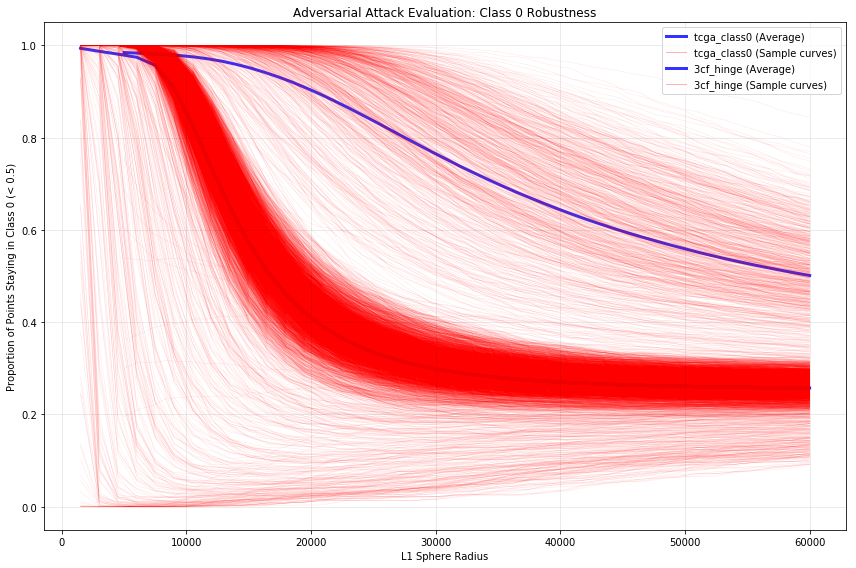

Plot saved to adversarial_attack_curves.png

Total evaluation time: 814.32 seconds


In [53]:
import torch
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 2000)
        self.bn1 = torch.nn.BatchNorm1d(2000)
        self.dropout1 = torch.nn.Dropout(0.02)
        self.fc2 = torch.nn.Linear(2000, 200)
        self.bn2 = torch.nn.BatchNorm1d(200)
        self.dropout2 = torch.nn.Dropout(0.02)
        self.fc3 = torch.nn.Linear(200, 20)
        self.bn3 = torch.nn.BatchNorm1d(20)
        self.dropout3 = torch.nn.Dropout(0.02)
        self.fc4 = torch.nn.Linear(20, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.leaky_relu = torch.nn.LeakyReLU(0.01)
        
    def forward(self, x):
        # Handle batch norm for single samples if needed
        if x.dim() == 2 and x.size(0) == 1:
            # For a single sample, clone it to make a batch of 2
            x_batch = torch.cat([x, x], dim=0)
            x_batch = self.leaky_relu(self.bn1(self.fc1(x_batch)))
            x_batch = self.dropout1(x_batch)
            x_batch = self.leaky_relu(self.bn2(self.fc2(x_batch)))
            x_batch = self.dropout2(x_batch)
            x_batch = self.leaky_relu(self.bn3(self.fc3(x_batch)))
            x_batch = self.dropout3(x_batch)
            x_batch = self.sigmoid(self.fc4(x_batch))
            return x_batch[0:1]  # Return only the first sample
        else:
            # Normal batch processing
            x = self.leaky_relu(self.bn1(self.fc1(x)))
            x = self.dropout1(x)
            x = self.leaky_relu(self.bn2(self.fc2(x)))
            x = self.dropout2(x)
            x = self.leaky_relu(self.bn3(self.fc3(x)))
            x = self.dropout3(x)
            x = self.sigmoid(self.fc4(x))
            return x

def load_model(model_path, input_size, device):
    """Load the pretrained MLP model"""
    model = MLP(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def sample_l1_sphere(n_points, dimensions, device):
    """
    Sample points evenly on the L1 sphere surface using coordinate-based method
    """
    # Use Dirichlet distribution for even sampling on L1 sphere
    # Sample from exponential distribution (equivalent to Dirichlet(1,1,...,1))
    samples = torch.empty(n_points, dimensions, device=device).exponential_(1.0)
    
    # Normalize to L1 norm = 1
    l1_norms = torch.sum(torch.abs(samples), dim=1, keepdim=True)
    samples = samples / l1_norms
    
    # Randomly assign signs to each coordinate
    signs = torch.randint(0, 2, (n_points, dimensions), device=device) * 2 - 1
    samples = samples * signs.float()
    
    return samples

def random_rotation_matrix(dimensions, device):
    """
    Generate a random rotation matrix using QR decomposition
    """
    # Generate random matrix
    A = torch.randn(dimensions, dimensions, device=device)
    
    # QR decomposition (use new API if available)
    try:
        Q, R = torch.linalg.qr(A, mode='reduced')
    except AttributeError:
        # Fallback for older PyTorch versions
        Q, R = torch.qr(A)
    
    # Ensure proper rotation (det = 1)
    Q = Q * torch.sign(torch.diag(R)).unsqueeze(0)
    
    return Q

def evaluate_adversarial_attacks(
    counterfactual_path,
    min_radius=0.1,
    max_radius=10.0,
    n_spheres=20,
    n_points_per_sphere=1000,
    model_path='mlp_model.pth',
    output_path='adversarial_attacks.json',
    inference_batch_size=512,  # Batch size for model inference, not for CFs
    gpu_id=0,
    plot_sample_size=50
):
    """
    Evaluate adversarial attacks by sampling points on L1 spheres around counterfactuals
    (REVISED FOR MEMORY EFFICIENCY - processes one counterfactual at a time)
    """
    start_time = time.time()
    
    # Set device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load counterfactual data (keep on CPU)
    print("Loading counterfactual data...")
    cf_df = pd.read_parquet(counterfactual_path)
    
    # Extract feature values (keep on CPU)
    if 'original_index' in cf_df.columns:
        cf_features_cpu = cf_df.iloc[:, 1:-1].values.astype(np.float32)
    else:
        cf_features_cpu = cf_df.iloc[:, 1:].values.astype(np.float32)
    
    n_counterfactuals, n_dimensions = cf_features_cpu.shape
    print(f"Loaded {n_counterfactuals} counterfactuals with {n_dimensions} features")
    
    # Load model
    print("Loading model...")
    model = load_model(model_path, n_dimensions, device)
    
    # Generate radius values
    radii = np.linspace(min_radius, max_radius, n_spheres)
    print(f"Evaluating {n_spheres} spheres from radius {min_radius} to {max_radius}")
    
    # Sample base points on unit L1 sphere
    print(f"Sampling {n_points_per_sphere} base points on unit L1 sphere...")
    base_points = sample_l1_sphere(n_points_per_sphere, n_dimensions, device)
    
    # Storage for results - initialize with empty lists for each radius
    attack_curves = [[] for _ in radii]
    
    # Process one counterfactual at a time to save memory
    for cf_idx in tqdm(range(n_counterfactuals), desc="Processing Counterfactuals"):
        cf_tensor = torch.tensor(cf_features_cpu[cf_idx], dtype=torch.float32, device=device)
        
        for radius_idx, radius in enumerate(radii):
            # For adversarial attacks, we can use the base points directly without rotation
            # This is more memory efficient and avoids potential GPU instability
            scaled_points = base_points * radius
            
            # Create adversarial points by adding the perturbation to the counterfactual
            # Shape: [n_points, n_dimensions]
            adversarial_points = scaled_points + cf_tensor
            
            # Process model inference in small batches to prevent OOM on large n_points_per_sphere
            all_predictions = []
            for chunk_start in range(0, len(adversarial_points), inference_batch_size):
                chunk_end = min(chunk_start + inference_batch_size, len(adversarial_points))
                chunk_points = adversarial_points[chunk_start:chunk_end]
                
                with torch.no_grad():
                    chunk_predictions = model(chunk_points)
                    all_predictions.append(chunk_predictions)
            
            predictions = torch.cat(all_predictions, dim=0)
            
            # Compute proportion of points that stay in class 0 (predictions < 0.5)
            stayed_in_class0 = (predictions < 0.5).float()
            proportion = torch.mean(stayed_in_class0).item()  # .item() moves to CPU
            
            attack_curves[radius_idx].append(proportion)

            # Clean up tensors for this radius
            del scaled_points, adversarial_points, all_predictions, predictions, stayed_in_class0
    
        # Clean up tensors for this counterfactual
        del cf_tensor

    # Prepare results
    results = {
        os.path.basename(counterfactual_path).replace('.parquet', ''): {
            'x_axis': radii.tolist(),
            'attack_curves': attack_curves
        }
    }

    # Save results to JSON
    print(f"\nSaving results to {output_path}")
    try:
        # Try to load existing results
        if os.path.exists(output_path):
            with open(output_path, 'r') as f:
                try:
                    existing_results = json.load(f)
                    print(f"Loaded existing results from {output_path}")
                    # Update with new results
                    existing_results.update(results)
                    results = existing_results
                except json.JSONDecodeError:
                    print("Could not parse existing JSON, creating new file")
        
        # Save updated results
        with open(output_path, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"Results saved to {output_path}")
        
    except Exception as e:
        print(f"Error saving results: {e}")
        backup_path = f"{output_path}.backup"
        with open(backup_path, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"Backup saved to {backup_path}")

    # Plot results
    plot_adversarial_curves(results, plot_sample_size)
    
    elapsed_time = time.time() - start_time
    print(f"\nTotal evaluation time: {elapsed_time:.2f} seconds")
    
    return results

def plot_adversarial_curves(results, plot_sample_size=50):
    """
    Plot adversarial attack curves
    """
    plt.figure(figsize=(12, 8))
    
    for method_name, data in results.items():
        x_axis = data['x_axis']
        attack_curves = data['attack_curves']
        
        # Convert to numpy array for easier manipulation
        curves_array = np.array(attack_curves)  # Shape: [n_radii, n_counterfactuals]
        
        # Compute average curve
        avg_curve = np.mean(curves_array, axis=1)
        
        # Plot average curve
        plt.plot(x_axis, avg_curve, 'b-', linewidth=3, label=f'{method_name} (Average)', alpha=0.8)
        
        # Plot sample of individual curves
        n_counterfactuals = curves_array.shape[1]
        if n_counterfactuals > plot_sample_size:
            # Randomly sample curves
            sample_indices = np.random.choice(n_counterfactuals, plot_sample_size, replace=False)
            sample_curves = curves_array[:, sample_indices]
        else:
            sample_curves = curves_array
        
        # Plot individual curves with transparency
        for i in range(sample_curves.shape[1]):
            plt.plot(x_axis, sample_curves[:, i], 'r-', alpha=0.1, linewidth=0.5)
        
        # Add one representative curve to legend
        if sample_curves.shape[1] > 0:
            plt.plot([], [], 'r-', alpha=0.3, linewidth=1, 
                    label=f'{method_name} (Sample curves)')
    
    plt.xlabel('L1 Sphere Radius')
    plt.ylabel('Proportion of Points Staying in Class 0 (< 0.5)')
    plt.title('Adversarial Attack Evaluation: Class 0 Robustness')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    # Save plot
    plot_path = 'adversarial_attack_curves.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Plot saved to {plot_path}")

# Example usage
if __name__ == "__main__":
    # Example parameters
    results = evaluate_adversarial_attacks(
        counterfactual_path='3cf_hinge.parquet',
        min_radius=1500,
        max_radius=60000,
        n_spheres=40,
        n_points_per_sphere=500,
        model_path='mlp_model.pth',
        output_path='adversarial_attacks_class0.json',
        inference_batch_size=512,  # Renamed batch_size to be more specific
        gpu_id=2,
        plot_sample_size=5000
    )